## Setup del entorno

Se cargan librerías estándar para análisis de datos. Se fija un estilo base para consistencia visual a lo largo del informe.

In [328]:
#Importamos librerías
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import kagglehub
from pathlib import Path
from scipy.stats import kruskal
import scipy.stats as ss
import matplotlib.ticker as mtick

sns.set_context("notebook")
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)

## Cargamos el dataset

In [274]:
# En Colab: suba saber_pro.csv al directorio de trabajo.
# En este entorno (local): si el archivo está en otra ruta, ajuste la línea.

try:
    data = pd.read_csv("saber_pro.csv")
except FileNotFoundError:
    data = pd.read_csv("/mnt/data/saber_pro.csv") #Ajustar la ruta

print("shape of loaded dataframe:", data.shape)
data.head()

shape of loaded dataframe: (692500, 21)


,ID,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,F_TIENEAUTOMOVIL,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_TIENEINTERNET.1,F_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,Si,N,No,Si,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,No,N,No,Si,No,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,No,N,No,No,Si,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,No,N,No,Si,Si,Secundaria (Bachillerato) completa,alto,0.485,0.172,0.252,0.190
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,Si,N,No,Si,Si,Primaria completa,medio-bajo,0.316,0.232,0.285,0.294


In [275]:
def audit(df: pd.DataFrame) -> pd.DataFrame:
    out = pd.DataFrame({
        "nulos_%": (df.isna().mean() * 100).round(2),
        "tipo": df.dtypes.astype(str),
        "nulos_n": df.isna().sum()
    }).sort_values("nulos_%", ascending=False)
    return out

In [276]:
audit(data)

,nulos_%,tipo,nulos_n
F_TIENEAUTOMOVIL,6.30,object,43623
F_TIENELAVADORA,5.74,object,39773
F_TIENECOMPUTADOR,5.50,object,38103
F_ESTRATOVIVIENDA,4.64,object,32137
E_HORASSEMANATRABAJA,4.46,object,30857
F_TIENEINTERNET.1,3.85,object,26629
F_TIENEINTERNET,3.85,object,26629
F_EDUCACIONMADRE,3.42,object,23664
F_EDUCACIONPADRE,3.35,object,23178
E_PAGOMATRICULAPROPIO,0.94,object,6498


## auditoria y transparencia

Para definir la estrategia de imputación, primero se identifican los registros que presentan más de dos valores nulos en sus columnas; estos registros se eliminan, ya que una imputación tan extensa introduciría un nivel de incertidumbre que podría distorsionar los análisis posteriores. De este modo, solo se imputan aquellos registros con faltantes limitados, donde la reconstrucción de la información es estadísticamente y operativamente confiable.

Sin embargo, verificamos si cambia la distribución del target (RENDIMIENTO_GLOBAL), dado que si Si cambia de forma relevante, la eliminación no es aceptable.

In [277]:
def drop_rows_with_many_nulls(df: pd.DataFrame, k: int = 2):
    """Elimina filas con k o más nulos. Retorna df_limpio y df_eliminados con trazabilidad."""
    null_count = df.isna().sum(axis=1)
    mask_drop = null_count >= k

    cols_nulas = (
        df[mask_drop]
        .isna()
        .apply(lambda row: list(df.columns[row]), axis=1)
    )

    df_eliminados = df[mask_drop].copy()
    df_eliminados["Columnas_Nulas"] = cols_nulas
    df_eliminados["N_Nulos"] = null_count[mask_drop]

    df_limpio = df[~mask_drop].copy()
    return df_limpio, df_eliminados

df = data.copy()
target = "RENDIMIENTO_GLOBAL"

df_limpio, df_eliminados = drop_rows_with_many_nulls(df, k=2)

print("Filas totales:", len(df))
print("Filas eliminadas:", len(df_eliminados))
print("Filas restantes:", len(df_limpio))
print("Porcentaje eliminado:", round(len(df_eliminados) / len(df) * 100, 2), "%")

dist_eliminados = df_eliminados[target].value_counts(normalize=True).mul(100).round(2)
dist_total      = df[target].value_counts(normalize=True).mul(100).round(2)

comparacion = pd.concat([dist_eliminados, dist_total], axis=1, keys=["Eliminados %", "Total %"])
comparacion["Diferencia_abs_pp"] = (comparacion["Eliminados %"] - comparacion["Total %"]).abs()

comparacion.sort_values("Diferencia_abs_pp", ascending=False)

Filas totales: 692500
Filas eliminadas: 47433
Filas restantes: 645067
Porcentaje eliminado: 6.85 %


,Eliminados %,Total %,Diferencia_abs_pp
RENDIMIENTO_GLOBAL,,,
bajo,32.75,24.98,7.77
alto,21.36,25.36,4.00
medio-alto,22.74,24.78,2.04
medio-bajo,23.15,24.88,1.73


En base a lo anterior, notamos que a pesar de que es importante realizar esta limpieza, para este dataset en partícular no se puede hacer, dado que se demostró que los nulos contienen información social y académica

Ahora, haremos un análisis de Missingness Patterns, para identificar qué tipo de estudiante “no reporta” información y por qué.

In [278]:
df = data.copy()
df["N_NULOS"] = df.isna().sum(axis=1)
# Resumen de nulos por clase de rendimiento
df.groupby("RENDIMIENTO_GLOBAL")["N_NULOS"].describe()



,count,mean,std,min,25%,50%,75%,max
RENDIMIENTO_GLOBAL,,,,,,,,
alto,175619.0,0.368542,1.625649,0.0,0.0,0.0,0.0,11.0
bajo,172987.0,0.552082,1.902238,0.0,0.0,0.0,0.0,11.0
medio-alto,171619.0,0.403166,1.676766,0.0,0.0,0.0,0.0,11.0
medio-bajo,172275.0,0.394491,1.627252,0.0,0.0,0.0,0.0,11.0


In [279]:
# Prueba no paramétrica: ¿distribución de N_NULOS cambia por clase de rendimiento?
groups = [df[df["RENDIMIENTO_GLOBAL"]==c]["N_NULOS"] for c in df["RENDIMIENTO_GLOBAL"].dropna().unique()]
stat, p = kruskal(*groups)
print("Kruskal-Wallis p-value:", p)


Kruskal-Wallis p-value: 0.0


El resultado Kruskal-Wallis p-value: 0.0 indica que existen diferencias estadísticamente significativas en la distribución del número de datos faltantes entre los distintos niveles de RENDIMIENTO_GLOBAL. En términos prácticos, esto significa que la cantidad de información no reportada no es la misma para todos los grupos de rendimiento académico: algunos niveles (típicamente los de menor rendimiento) concentran sistemáticamente más valores nulos que otros.

Desde el punto de vista estadístico, el test de Kruskal–Wallis contrasta la hipótesis nula de que varias poblaciones independientes provienen de la misma distribución. Un p-value cercano a cero (o reportado como 0.0 por límites numéricos de la máquina) implica que la probabilidad de observar diferencias tan marcadas bajo la hipótesis de igualdad es prácticamente nula. Por lo tanto, se rechaza la hipótesis nula y se concluye que el patrón de datos faltantes depende del nivel de rendimiento académico.

Por lo tanto, estos nulos no se pueden tomar como ruido aleatorio, sino de interpretarlos como un reflejo de desigualdades sociales y académicas subyacentes, que deben ser preservadas y modeladas cuidadosamente para no distorsionar los análisis posteriores ni las conclusiones que se tengan de este informe

In [280]:
df["MISSING_HEAVY"] = (df["N_NULOS"] >= 2).astype(int)

def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion)[0]
    n = confusion.sum().sum()
    r, k = confusion.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

candidate_cols = [
    "F_ESTRATOVIVIENDA",
    "F_TIENECOMPUTADOR",
    "F_TIENEINTERNET",
    "F_TIENEAUTOMOVIL",
    "E_EDAD",
    "E_PRGM_DEPARTAMENTO",
    "E_EDUCACIONPADRE",
    "E_EDUCACIONMADRE"
]

missing_assoc = {}
for col in candidate_cols:
    if col in df.columns:
        missing_assoc[col] = cramers_v(df[col], df["MISSING_HEAVY"])

pd.Series(missing_assoc).sort_values(ascending=False)


,0
F_ESTRATOVIVIENDA,0.035668
F_TIENEAUTOMOVIL,0.029105
E_PRGM_DEPARTAMENTO,0.028195
F_TIENEINTERNET,0.008728
F_TIENECOMPUTADOR,0.000945


Se identificó que el patrón de datos faltantes es MNAR (Missing Not At Random).
Los estudiantes de bajo rendimiento presentan significativamente más datos faltantes (media 0.55 vs 0.37, Kruskal-Wallis p<0.001).
Variables socioeconómicas como estrato de vivienda, posesión de automóvil y región académica muestran asociación significativa con la presencia de datos faltantes (Cramér’s V > 0.03).
Esto sugiere que los nulos capturan desigualdad estructural y no pueden ser tratados como ruido.

Teniendo en cuenta esto, Se debe imputar por grupo socioeconómico o por rendimiento

In [281]:
data_imp = data.copy()

# 1) Eliminar columna duplicada si existe
if "F_TIENEINTERNET.1" in data_imp.columns:
    data_imp = data_imp.drop(columns=["F_TIENEINTERNET.1"])

group_vars = ["F_ESTRATOVIVIENDA", "E_PRGM_DEPARTAMENTO"]

# Rellenar grupos faltantes (no queremos perder filas por falta de grupo)
for col in group_vars:
    if col in data_imp.columns:
        data_imp[col] = data_imp[col].fillna("Desconocido")

vars_with_nulls = [
    "F_TIENEAUTOMOVIL",
    "F_TIENELAVADORA",
    "F_TIENECOMPUTADOR",
    "E_HORASSEMANATRABAJA",
    "F_TIENEINTERNET",
    "F_EDUCACIONMADRE",
    "F_EDUCACIONPADRE",
    "E_PAGOMATRICULAPROPIO",
    "E_VALORMATRICULAUNIVERSIDAD"
]

# Imputación por tipo
for col in vars_with_nulls:
    if col not in data_imp.columns:
        continue

    if pd.api.types.is_numeric_dtype(data_imp[col]):
        data_imp[col] = (
            data_imp.groupby(group_vars)[col]
            .transform(lambda x: x.fillna(x.median()))
        )
    else:
        data_imp[col] = (
            data_imp.groupby(group_vars)[col]
            .transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else "Desconocido"))
        )

# Validación: % de nulos restantes en variables tratadas
(data_imp[vars_with_nulls].isna().mean() * 100).round(2)




,0
F_TIENEAUTOMOVIL,0.0
F_TIENELAVADORA,0.0
F_TIENECOMPUTADOR,0.0
E_HORASSEMANATRABAJA,0.0
F_TIENEINTERNET,0.0
F_EDUCACIONMADRE,0.0
F_EDUCACIONPADRE,0.0
E_PAGOMATRICULAPROPIO,0.0
E_VALORMATRICULAUNIVERSIDAD,0.0


No es suficiente aplicar una técnica de imputación y asumir que es adecuada; resulta indispensable demostrar empíricamente que dicho procedimiento no altera ni debilita la relación estructural entre las variables socioeconómicas y el rendimiento académico. Por esta razón, se realiza una validación posterior a la imputación, comparando los valores de Cramér’s V antes y después del tratamiento de los datos faltantes. Esta verificación permite comprobar que la fuerza de asociación entre las variables imputadas y el rendimiento se mantiene estable, garantizando que la imputación preserva la información sustantiva del fenómeno analizado y no introduce distorsiones artificiales en los resultados.

In [282]:
target = "RENDIMIENTO_GLOBAL"

def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion)[0]
    n = confusion.sum().sum()
    r, k = confusion.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

cramers_before = {}
cramers_after  = {}

for col in vars_with_nulls:
    if col not in data.columns or col not in data_imp.columns:
        continue
    cramers_before[col] = cramers_v(data[col], data[target])
    cramers_after[col]  = cramers_v(data_imp[col], data_imp[target])

comparison = pd.DataFrame({"Antes": cramers_before, "Después": cramers_after})
comparison["Cambio"] = comparison["Después"] - comparison["Antes"]
comparison.sort_values("Cambio", ascending=False)

,Antes,Después,Cambio
F_TIENEAUTOMOVIL,0.166917,0.167982,0.001064
E_PAGOMATRICULAPROPIO,0.201337,0.200709,-0.000627
E_VALORMATRICULAUNIVERSIDAD,0.217570,0.216594,-0.000976
E_HORASSEMANATRABAJA,0.098864,0.095256,-0.003608
F_EDUCACIONMADRE,0.176288,0.172251,-0.004037
F_EDUCACIONPADRE,0.169865,0.165753,-0.004112
F_TIENEINTERNET,0.147952,0.143007,-0.004946
F_TIENELAVADORA,0.114881,0.107038,-0.007843
F_TIENECOMPUTADOR,0.141365,0.133472,-0.007893


La imputación condicional preservó la estructura informativa de las variables socioeconómicas.
Las variaciones en Cramér’s V antes y después de imputar fueron inferiores a 0.01 en todos los casos, lo que indica que el procedimiento no introdujo distorsión significativa en la relación con el rendimiento académico.

### Atípicos (outliers) por clase de rendimiento

En educación, valores atípicos no siempre son “ruido”; pueden ser **perfiles en transición** (ej. estudiantes vulnerables con buen desempeño, o viceversa). Por eso cuantificamos outliers por clase, en vez de eliminarlos automáticamente.

In [283]:
vars_num = [c for c in ["INDICADOR_1","INDICADOR_2"] if c in data_imp.columns]
target = "RENDIMIENTO_GLOBAL"

outliers = []
for col in vars_num:
    for cls in data_imp[target].dropna().unique():
        subset = data_imp.loc[data_imp[target] == cls, col].dropna()
        q1, q3 = subset.quantile(0.25), subset.quantile(0.75)
        iqr = q3 - q1
        low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
        pct = ((subset < low) | (subset > high)).mean() * 100
        outliers.append([col, cls, round(pct, 2), low, high])

pd.DataFrame(outliers, columns=["Variable","Clase","% Outliers","Low","High"])



,Variable,Clase,% Outliers,Low,High
0,INDICADOR_1,medio-alto,10.67,0.0465,0.4745
1,INDICADOR_1,bajo,2.37,-0.0250,0.4870
2,INDICADOR_1,alto,0.00,-0.1125,0.7795
3,INDICADOR_1,medio-bajo,9.73,0.0425,0.4625
4,INDICADOR_2,medio-alto,4.61,0.0750,0.4430
5,INDICADOR_2,bajo,0.00,-0.0035,0.6085
6,INDICADOR_2,alto,0.09,-0.0150,0.4730
7,INDICADOR_2,medio-bajo,4.67,0.0855,0.4495


Los grupos intermedios (medio-alto y medio-bajo) concentran los casos atípicos, por lo que en el ambito educativo, puede ser que estudiantes en transacción, mezcla de perfiles, pero no es ruido


### Reducción de cardinalidad

`E_PRGM_ACADEMICO` suele tener alta cardinalidad, es por esto, que para un análisis cualitativo reduce el ruida, facilita comparaciones, permite diseñar políticas focalizadas por áreas del conocimiento.


In [284]:
grupo_dict = {
    'CIENCIAS_SOCIALES': [
        'DERECHO','LICENCIATURA EN CIENCIAS SOCIALES', 'LICENCIATURA EN ETNOEDUCACION','CIENCIAS POLITICAS',
        'LICENCIATURA EN FILOSOFIA', 'LICENCIATURA EN CIENCIAS RELIGIOSAS','CIENCIA POLITICA',
        'TRABAJO SOCIAL', 'LICENCIATURA EN FILOSOFÍA', 'RELACIONES INTERNACIONALES', 'JURISPRUDENCIA',
        'SOCIOLOGIA', 'FILOSOFIA', 'LICENCIATURA EN FILOSOFIA Y EDUCACION RELIGIOSA', 'LICENCIATURA EN TEOLOGIA',
        'PLANEACION Y DESARROLLO SOCIAL', 'PROFESIONAL EN CRIMINALISTICA',
        'LICENCIATURA EN ETNOEDUCACION CON ENFASIS EN CIENCIAS SOCIALES', 'CIENCIA POLÍTICA Y GOBIERNO',
        'ANTROPOLOGIA', 'CIENCIAS BIBLICAS', 'HISTORIA',  'PROFESIONAL EN TRABAJO SOCIAL', 'CIENCIA POLÍTICA',
        'TEOLOGIA', 'CIENCIA POLITICA Y GOBIERNO', 'CIENCIA POLITICA Y RELACIONES INTERNACIONALES',
        'RELACIONES INTERNACIONALES Y ESTUDIOS POLITICOS',  'GOBIERNO Y RELACIONES INTERNACIONALES',
        'GESTION CULTURAL Y COMUNICATIVA', 'LICENCIATURA EN ETNOEDUCACION Y DESARROLLO COMUNITARIO',
        'DERECHO Y CIENCIAS POLITICAS', 'CRIMINALISTICA', 'LICENCIATURA EN CIENCIAS RELIGIOSAS',
        'CIENCIAS POLÍTICAS', 'TEOLOGÍA', 'FILOSOFIA Y LETRAS', 'FILOSOFÍA', 'HISTORIA Y PATRIMONIO',
        'GERENCIA DE LA SEGURIDAD Y ANALISIS SOCIO POLITICO', 'LICENCIATURA EN FILOSOFIA',
        'INVESTIGACIÓN CRIMINAL', 'LICENCIATURA EN TEOLOGÍA',
        'DESARROLLO FAMILIAR','LICENCIATURA EN HISTORIA','SOCIOLOGÍA','POLITICA Y RELACIONES INTERNACIONALES',
        'DERECHO Y CIENCIAS SOCIALES', 'GOBIERNO Y ASUNTOS PUBLICOS','ESTUDIOS EN FILOSOFIA',
        'LICENCIATURA EN CIENCIAS SOCIALES Y DESARROLLO LOCAL',
        'PERIODISMO Y OPINION PUBLICA','FILOSOFÍA Y HUMANIDADES','DESARROLLO TERRITORIAL',
        'GEOGRAFIA DEL DESARROLLO REGIONAL Y AMBIENTAL','DERECHO Y CIENCIAS POLÍTICAS',
        'ACUICULTURA','LICENCIATURA EN EDUCACION COMUNITARIA CON ENFASIS EN DERECHOS HUMANOS',
        'CIENCIA POLITICA, GOBIERNO Y RELACIONES INTERNACIONALES','ESTUDIOS Y GESTIÓN CULTURAL',
        'FILOSOFIA Y HUMANIDADES', 'TERAPIAS PSICOSOCIALES', 'ANTROPOLOGÍA',
        'PROFESIONAL EN FILOSOFIA', 'LENGUAJES Y ESTUDIOS SOCIOCULTURALES', 'URBANISMO',
        'ESTUDIOS Y GESTION CULTURAL','ESTUDIOS POLITICOS Y RESOLUCION DE CONFLICTOS',
        'LICENCIATURA EN EDUCACION BASICA ENFASIS EN CIENCIAS SOCIALES',
        'GESTIÓN CULTURAL','GESTIÓN  DE SISTEMAS DE INFORMACIÓN','INVESTIGACION CRIMINAL',
        'PROFESIONAL EN INVESTIGACIÓN CRIMINAL', 'ARQUEOLOGIA',
        ],

    'CIENCIAS_ECONOMICAS': [
        'ECONOMIA', 'MERCADEO Y PUBLICIDAD', 'CONTADURIA PÚBLICA', 'CONTADURÍA PÚBLICA', 'MARKETING Y LOGISTICA',
        'CONTADURIA PUBLICA', 'NEGOCIOS INTERNACIONALES', 'FINANZAS Y COMERCIO INTERNACIONAL',
        'PROFESIONAL EN FINANZAS Y NEGOCIOS INTERNACIONALES', 'FINANZAS Y NEGOCIOS INTERNACIONALES',
        'ECONOMÍA','MERCADEO Y NEGOCIOS INTERNACIONALES', 'ECONOMIA Y FINANZAS INTERNACIONALES',
        'MERCADEO', 'ECONOMIA Y NEGOCIOS INTERNACIONALES', 'NEGOCIOS Y RELACIONES INTERNACIONALES',
        'NEGOCIOS INTERNACIONALES SEGUNDO CICLO',  'PROFESIONAL EN CONTADURIA PUBLICA', 'PROFESIONAL EN AGRONEGOCIOS',
        'RELACIONES ECONOMICAS INTERNACIONALES', 'ADMINISTRACION BANCARIA Y FINANCIERA', 'MERCADOLOGIA',
        'COMERCIO Y NEGOCIOS INTERNACIONALES', 'FINANZAS Y COMERCIO EXTERIOR', 'COMERCIO EXTERIOR',
        'NEGOCIOS Y FINANZAS INTERNACIONALES', 'COMERCIO INTERNACIONAL Y FINANZAS', 'FINANZAS Y RELACIONES INTERNACIONALES',
        'COMERCIO INTERNACIONAL', 'FINANZAS', 'CONTADURIA PUBLICA Y FINANZAS INTERNACIONALES',
        'PROFESIONAL EN BANCA Y FINANZAS', 'CONTADURÍA PÚBLICA.', 'CONTADURIA', 'PROFESIONAL EN NEGOCIOS INTERNACIONALES',
        'PROFESIONAL EN MARKETING Y NEGOCIOS INTERNACIONALES', 'MERCADEO NACIONAL E INTERNACIONAL',
        '3°  CICLO PROFESIONAL NEGOCIOS INTERNACIONALES', 'MARKETING Y NEGOCIOS INTERNACIONALES',
        'PRODUCCION AGROINDUSTRIAL','CONTADURÍA INTERNACIONAL','PUBLICIDAD INTERNACIONAL','PROFESIONAL EN MERCADEO',
        'CONTADURÍA PUBLICA','BANCA Y FINANZAS','PROFESIONAL EN MERCADEO EMPRESARIAL',
        'MERCADEO AGROINDUSTRIAL','ECONOM¿A','MERCADEO INTERNACIONAL Y PUBLICIDAD',
        'CONTADURIA P¿BLICA','LOGISTICA Y MERCADEO ORGANIZACIONAL',
        'CONTADURIA PUBLICA ENFASIS EN SISTEMAS Y ECONOMIA SOLIDARIA', 'MERCADEO Y VENTAS',
        'PROFESIONAL EN MARKETING INTERNACIONAL','GESTION EN ECOLOGIA Y TURISMO',
        'COMERCIO Y FINANZAS INTERNACIONALES', 'PROFESIONAL EN PUBLICIDAD Y MERCADEO',
        'BANCA Y FINANZAS INTERNACIONALES',
        ],

    'PEDAGOGIA': [
        'LICENCIATURA EN PEDAGOGIA INFANTIL', 'LICENCIATURA EN EDUCACION PREESCOLAR',
        'LICENCIATURA EN PSICOLOGIA Y PEDAGOGIA', 'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN HUMANIDADES-INGLES',
        'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN CIENCIAS NATURALES Y EDUCACION AMBIENTAL',
        'LICENCIATURA EN EDUCACION BÁSICA CON ÉNFASIS EN CIENCIAS NATURALES Y EDUCACIÓN AMBIENTAL',
        'LICENCIATURA EN EDUCACION PREESCOLAR', 'LICENCIATURA EN PSICOLOGIA Y PEDAGOGIA',
        'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN HUMANIDADES E IDIOMAS', 'LICENCIATURA EN PEDAGOGÍA INFANTIL',
        'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN EDUCACION FISICA, RECREACION Y DEPORTES',
        'LICENCIATURA EN EDUCACION PARA LA PRIMERA INFANCIA', 'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN MATEMATICAS',
        'LICENCIATURA EN EDUCACIÓN BÁSICA CON ÉNFASIS EN INGLÉS', 'LICENCIATURA EN EDUCACIÓN PARA LA PRIMERA INFANCIA',
        'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN LENGUA CASTELLANA', 'LICENCIATURA EN EDUCACION INFANTIL',
        'LICENCIATURA EN EDUCACIÓN BÁSICA PRIMARIA', 'LICENCIATURA EN EDUCACIÓN INFANTIL',
        'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN MATEMATICA HUMANIDADES Y LENGUA CASTELLANA',
        'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN EDUCACION FISICA,RECREACION Y DEPORTES',
        'LICENCIATURA EN PEDAGOGIA  INFANTIL', 'LICENCIATURA EN EDUCACIÓN BÁSICA CON ÉNFASIS EN EDUCACIÓN ARTÍSTICA',
        'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN LENGUAS EXTRANJERAS', 'LICENCIATURA EN EDUCACION ESPECIAL',
        'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN HUMANIDADES: LENGUA CASTELLANA E INGLES',
        'LICENCIATURA EN EDUCACION CON ENFASIS EN EDUCACION ESPECIAL', 'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN INGLES',
        'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN HUMANIDADES Y LENGUA CASTELLANA',
        'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN CIENCIAS SOCIALES', 'LICENCIATURA EN EDUCACION POPULAR',
        'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN HUMANIDADES -  LENGUA CASTELLANA',
        'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN EDUCACION FISICA,RECREACION Y DEPORTE',
        'LICENCIATURA EN EDUCACIÓN BÁSICA CON ÉNFASIS EN HUMANIDADES- LENGUA CASTELLANA',
        'LICENCIATURA EN EDUCACIÓN BÁSICA CON ÉNFASIS EN HUMANIDADES, LENGUA CASTELLANA',
        'LICENCIATURA EN EDUCACIÓN BÁSICA, CON ÉNFASIS EN HUMANIDADES, LENGUA CASTELLANA',
        'LICENCIATURA EN EDUCACIÓN BÁSICA CON ÉNFASIS EN CIENCIAS SOCIALES', 'LICENCIATURA EN EDUCACION AMBIENTAL',
        'LICENCIATURA EN EDUCACION RELIGIOSA', 'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN INFORMATICA',
        'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN HUMANIDADES, ESPAÑOL Y LENGUAS EXTRANJERAS',
        'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN EDUCACION ARTISTICA', 'LICENCIATURA EN EDUCACIÓN ESPECIAL',
        'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN HUMANIDADES,LENGUA CASTELLANA E INGLES',
        'LICENCIATURA EN EDUCACION BASICA  CON ENFASIS EN HUMANIDADES Y LENGUA CASTELLANA',
        'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN HUMANIDADES, LENGUA CASTELLANA',
        'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN LENGUA CASTELLANA E INGLES', 'LICENCIATURA EN EDUCACION INDUSTRIAL',
        'LICENCIATURA EN INGLÉS-ESPAÑOL', 'LICENCIATURA EN PEDAGOGÍA SOCIAL PARA LA REHABILITACIÓN',
        'LICENCIATURA  PEDAGOGIA INFANTIL', 'LICENCIATURA EN PEDAGOG¿A INFANTIL', 'LICENCIATURA EN PEDAGOGIA DE LA PRIMERA INFANCIA',
        'LICENCIATURA EN PREESCOLAR', 'LICENCIATURA EN INFORMATICA', 'LICENCIATURA EN TECNOLOGIA E INFORMATICA','LICENCIATURA EN INFORMATICA EDUCATIVA',
        'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN TECNOLOGIA E INFORMATICA',
        'LICENCIATURA EN EDUCACION BILINGUE', 'LICENCIATURA EN EDUCACION BASICA ENFASIS EN CIENCIAS NATURALES Y EDUCACION AMBIENTAL',
        'LICENCIATURA EN EDUCACION BASICA, ENFASIS EN CIENCIAS NATURALES Y EDUCACION AMBIENTAL',
        'LICENCIATURA EN EDUCACION BASICA EN CIENCIAS NATURALES Y EDUCACION AMBIENTAL',
        'LICENCIATURA EN LITERATURA Y LENGUA CASTELLANA', 'LICENCIATURA EN FILOSOFIA E HISTORIA',
        'LICENCIATURA EN ELECTRONICA','LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN HUMANIDADES: ESPAÑOL E INGLES',
        'LICENCIATURA EN EDUCACIÓN BÁSICA CON ÉNFASIS EN HUMANIDADES LENGUA CASTELLANA',
        'LICENCIATURA EN PRODUCCION AGROPECUARIA','LICENCIATURA EN RECREACION',
        'LICENCIATURA EN CIENCIAS SOCIALES CON ÉNFASIS EN EDUCACIÓN BÁSICA',
        'LICENCIATURA EN FILOSOFIA, PENSAMIENTO POLITICO Y ECONOMICO',
        'LICENCIATURA EN EDUCACI¿N B¿SICA PRIMARIA', 'LICENCIATURA EN FILOSOFIA Y LETRAS',
        'LICENCIATURA EN  LITERATURA Y LENGUA CASTELLANA', 'LICENCIATURA EN EDUCACIÓN PREESCOLAR',
        'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN  HUMANIDADES, LENGUA CASTELLANA E INGLES',
        'LICENCIATURA EN EDUCACIÓN PARA LA CONVIVENCIA Y EL DESARROLLO HUMANO',
        'LICENCIATURA EN PSICOPEDAGOGIA CON ENFASIS EN ASESORIA EDUCATIVA','LICENCIATURA EN BIOLOGÍA',
        'LICENCIATURA EN EDUCACI¿N CON ¿NFASIS EN CIENCIAS SOCIALES Y AMBIENTALES',
        'LICENCIATURA EN MATEMATICAS E INFORMATICA','LICENCIATURA EN EDUCACIÓN ARTÍSTICA Y CULTURAL',
        'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN HUMANIDADES,LENGUA CASTELLANA',
        'LICENCIATURA EN  FILOSOFIA Y CIENCIAS RELIGIOSAS', 'LICENCIATURA EN EDUCACI¿N INFANTIL',
        'LICENCIATURA EN EDUCACION BASICA PRIMARIA','LICENCIATURA EN EDUCACIÓN  FÍSICA, RECREACIÓN Y DEPORTE',
        'LICENCIATURA EN EDUCACION PREESCOLAR CON ENFASIS EN INGLES',
        'LICENCIATURA EN PEDAGOGÍA DE LA MADRE TIERRA', 'LICENCIATURA EN  FILOSOFIA',
        'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN MATEMATICAS E INFORMATICA',
        'LICENCIATURA EN EDUCACION RELIGIOSA CON ENFASIS EN BIBLIA',
        'LICENCIATURA EN FILOSOFIA Y HUMANIDADES','PEDAGOGÍA',
        'LICENCIATURA EN FILOSOFIA, ETICA Y VALORES HUMANOS',
        'LICENCIATURA EN EDUCACIÓN BÁSICA CON ÉNFASIS EN EDUCACIÓN ARTÍSTICA Y CULTURAL',
        'LICENCIATURA EN FILOSOF¿A Y HUMANIDADES','LICENCIATURA EN HUMANIDADES',
        'LICENCIATURA EN CIENCIAS NATURALES: FÍSICA QUÍMICA Y BIOLOGÍA',
        'LICENCIATURA EN PEDAGOGIA REEDUCATIVA','LICENCIATURA EN EDUCACION INICIAL',
        'LICENCIATURA  EN  CIENCIAS  SOCIALES', 'LICENCIATURA EN TECNOLOGÍA E INFORMÁTICA',
        'LICENCIATURA EN QUIMICA Y EDUCACION AMBIENTAL', 'LICENCIATURA EN EDUCACION ENFASIS EN INFORMATICA',
        'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN EL AREA DE TECNOLOGIA E INFORMATICA',
        'LICENCIATURA EN EDUCACION ENFASIS EN CIENCIAS SOCIALES',
        'LICENCIATURA EN EDUCACION BASICA PRIMARIA:ENFASIS EN CIENCIAS SOCIALES',
        'LICENCIATURA EN CIENCIAS DE LA EDUCACION',
        ],

    'CIENCIAS_EXACTAS_NATURALES': [
        'LICENCIATURA EN BIOLOGIA', 'LICENCIATURA EN CIENCIAS NATURALES', 'GEOGRAFIA', 'LICENCIATURA EN QUIMICA',
        'LICENCIATURA EN BIOLOGIA Y EDUCACION AMBIENTAL', 'ZOOTECNIA', 'ADMINISTRACION AMBIENTAL',
        'MEDICINA VETERINARIA Y ZOOTECNIA',  'QUIMICA FARMACEUTICA',  'ADMINISTRACION DEL MEDIO AMBIENTE',
        'LICENCIATURA EN BIOLOGIA Y QUIMICA', 'ADMINISTRACION AMBIENTAL Y DE LOS RECURSOS NATURALES',
        'ADMINISTRACION MARITIMA Y FLUVIAL', 'LICENCIATURA EN CIENCIAS NATURALES Y EDUCACION AMBIENTAL',
        'BIOLOGIA', 'BACTERIOLOGIA', 'AGRONOMIA', 'BACTERIOLOGIA Y LABORATORIO CLINICO',
        'LICENCIATURA EN  CIENCIAS NATURALES Y EDUCACION AMBIENTAL',  'ADMINISTRACION Y GESTION AMBIENTAL',
        'GEOLOGIA', 'INGENIERÍA AMBIENTAL Y SANITARIA', 'INGENIERIA AMBIENTAL Y DE SANEAMIENTO', 'QUIMICA',
        'MICROBIOLOGIA Y BIOANALISIS', 'ECOLOGIA DE ZONAS COSTERAS', 'LICENCIATURA EN CIENCIAS NATURALES',
        'BIOLOGÍA', 'MICROBIOLOGIA', 'LICENCIATURA EN BIOLOGIA CON ENFASIS EN EDUCACION AMBIENTAL',
        'BIOLOGIA APLICADA', 'MICROBIOLOGIA INDUSTRIAL Y AMBIENTAL', 'GEOCIENCIAS', 'GEOLOG¿A', 'QUIMICA INDUSTRIAL',
        'ECOLOGIA', 'LICENCIATURA EN CIENCIAS NATURALES Y EDUCACIÓN AMBIENTAL',
        'LICENCIATURA EN MATEMÁTICAS Y FÍSICA', 'MICROBIOLOGÍA', 'QUIMICA.',
        'LICENCIATURA EN EDUCACIÓN BÁSICA CON ÉNFASIS EN CIENCIAS NATURALES Y EDUCACIÓN AMBIENTAL',
        'AGRONOMIA DEL TROPICO HUMEDO','BIOLOGIA MARINA','ESTADÍSTICA','ASTRONOMIA',
        'OCEANOGRAFIA FISICA', 'BIOLOGÍA AMBIENTAL', 'QUÍMICA INDUSTRIAL', 'QUIMICA AMBIENTAL',
        'MICROBIOLOGIA INDUSTRIAL','MICROBIOLOGÍA INDUSTRIAL Y AMBIENTAL', 'BIOQUIMICA',
        'QU¿MICA FARMAC¿UTICA','ECOLOGÍA','BIOLOGIA AMBIENTAL','MICROBIOLOGÍA Y BIOANÁLISIS',
        'GEOLOGÍA','QUÍMICA FARMACÉUTICA', 'QUÍMICA', 'OCEANOGRAFÍA', 'CIENCIAS AMBIENTALES',
        'PROFESIONAL EN AGROINDUSTRIA', 'QUIMICA Y FARMACIA','PROFESIONAL EN  AGROINDUSTRIA',
        'ESTADISTICA', 'LICENCIATURA EN MATEMATICAS', 'FÍSICA', 'FISICA', 'LICENCIATURA EN MATEMATICAS Y FISICA',
        'LICENCIATURA EN MATEMATICAS Y ESTADISTICA', 'MATEMATICAS', 'LICENCIATURA  EN MATEMATICAS', 'MATEMÁTICA APLICADA',
        'LICENCIATURA EN MATEMÁTICAS', 'LICENCIATURA EN INGLES - ESPAÑOL','MATEMATICAS CON ENFASIS EN ESTADISTICA',
        'LICENCIATURA EN MATEMATICAS Y TECNOLOGIAS DE LA INFORMACION',
        'MATEMÁTICAS', 'LICENCIATURA EN  MATEMATICAS Y FISICA', 'MATEMÁTICAS APLICADAS Y CIENCIAS DE LA COMPUTACIÓN',
        'CIENCIAS DE LA COMPUTACION','MATEMATICAS APLICADAS', 'COMPUTACIÓN CIENTÍFICA','LICENCIATURA EN MATEM¿TICAS',
        'LICENCIATURA EN FÍSICA', 'CIENCIAS DE LA COMPUTACIÓN E INTELIGENCIA ARTIFICIAL',
        ],

    'EDUCACION_FISICA': [
        'LICENCIATURA EN EDUCACION FISICA, RECREACION Y DEPORTE','LICENCIATURA EN EDUCACION FISICA Y DEPORTES',
        'LICENCIATURA EN EDUCACIÓN FÍSICA, RECREACIÓN Y DEPORTE', 'PROFESIONAL EN DEPORTE', 'ENTRENAMIENTO DEPORTIVO',
        'CIENCIAS DEL DEPORTE Y DE LA EDUCACION FISICA', 'LICENCIATURA EN EDUCACION FISICA, DEPORTES Y RECREACION',
        'LICENCIATURA EN CIENCIAS DEL DEPORTE', 'LICENCIATURA EN EDUCACION FISICA Y DEPORTES', 'LICENCIATURA EN EDUCACION FISICA',
        'LICENCIATURA EN EDUCACIÓN FÍSICA Y DEPORTES', 'LICENCIATURA EN EDUCACION  FISICA RECREACION  Y  DEPORTE',
        'LICENCIATURA EN EDUCACION BASICA ENFASIS EN EDUCACION FISICA, RECREACION Y DEPORTE',
        'LICENCIATURA EN EDUCACION FISICA,RECREACION Y DEPORTES', 'LICENCIATURA EN EDUCACION FISICA RECREACION Y DEPORTE',
        'LICENCIATURA EN EDUCACION FISICA, RECREACION Y DEPORTES', 'LICENCIATURA EN EDUCACION FISICA,RECREACION Y DEPORTE',
        'ADMINISTRACION DEPORTIVA', 'PROFESIONAL EN ACTIVIDAD FISICA Y DEPORTE', 'DEPORTE Y ACTIVIDAD FISICA',
        'CULTURA FISICA, DEPORTE Y RECREACION', 'LICENCIATURA EN CULTURA, FISICA, RECREACION Y DEPORTES',
        'LICENCIATURA EN FISICA', 'CULTURA FISICA Y DEPORTE', 'PROFESIONAL EN ENTRENAMIENTO DEPORTIVO',
        'LICENCIATURA EN DEPORTE', 'CIENCIAS DEL DEPORTE', 'DEPORTE',
        'CIENCIAS DEL DEPORTE Y  LA RECREACION', 'LICENCIATURA EN CIENCIAS DEL DEPORTE Y LA EDUCACION FISICA',
        'LICENCIATURA EN EDUCACION FISICA, RECREACION Y DEPORTE','DEPORTE Y CULTURA FISICA',
        'ACTIVIDAD FISICA Y DEPORTE','LICENCIATURA EN EDUCACIÓN FÍSICA Y DEPORTE',
        'PROFESIONAL EN ACTIVIDAD FÍSICA Y DEPORTE','CIENCIAS DEL DEPORTE Y LA ACTIVIDAD FISICA',
        'LICENCIATURA EN EDUCACIÓN  FÍSICA, RECREACIÓN Y DEPORTES', 'GESTI¿N DEPORTIVA',
        'LICENCIATURA EN EDUCACIÓN FÍSICA DEPORTES Y RECREACIÓN', 'RECREACION',
        'PROFESIONAL EN CIENCIAS DEL DEPORTE Y LA EDUCACION FISICA',
        'FORMACION PROFESIONAL EN DEPORTE', 'DEPORTE Y ACTIVIDADA FISICA',
        'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN EDUCACION  FISICA, DEPORTES Y RECREACION',
        'LICENCIATURA EN EDUCACI¿N F¿SICA RECREACI¿N Y DEPORTES',
        'LICENCIATURA EN EDUCACION FISICA, DEPORTE Y RECREACION ENFASIS RURAL',
        'LICENCIATURA EN EDUCACON FISICA, RECREACION Y DEPORTES',
        ],

    'IDIOMAS_LETRAS': [
        'LICENCIATURA EN LENGUAS EXTRANJERAS', 'LICENCIATURA EN INGLES', 'LITERATURA',
        'LICENCIATURA EN BILINGÜISMO CON ÉNFASIS EN INGLÉS', 'LICENCIATURA EN INGLÉS',
        'LICENCIATURA EN LENGUAS EXTRANJERAS', 'LICENCIATURA EN BILINGÜISMO CON ÉNFASIS EN INGLÉS',
        'LICENCIATURA EN LENGUA CASTELLANA,INGLES Y FRANCES', 'LICENCIATURA EN IDIOMAS EXTRANJEROS',
        'ESTUDIOS LITERARIOS', 'LICENCIATURA EN LENGUAS MODERNAS CON ENFASIS EN INGLES Y FRANCES',
        'LICENCIATURA EN INGLES', 'FILOLOGIA E IDIOMAS', 'LICENCIATURA EN LENGUA CASTELLANA E INGLES',
        'TRADUCCION INGLES-FRANCES-ESPAÑOL', 'LICENCIATURA EN LENGUA CASTELLANA Y COMUNICACION',
        'PROFESIONAL EN LENGUAS MODERNAS', 'LINGUISTICA Y LITERATURA', 'LICENCIATURA EN ESPAÑOL Y LITERATURA',
        'LINGUISTICA', 'LICENCIATURA EN LENGUAS MODERNAS', 'LENGUAS MODERNAS', 'LICENCIATURA EN ESPAÑOL Y LENGUAS EXTRANJERAS',
        'LICENCIATURA EN LENGUAS MODERNAS INGLES-FRANCES', 'LICENCIATURA EN LENGUA EXTRANJERA INGLES',
        'LETRAS - FILOLOGIA HISPANICA', 'LICENCIATURA EN IDIOMAS MODERNOS ESPAÑOL- INGLES', 'ESPAÑOL Y FILOLOGIA CLASICA',
        'LICENCIATURA EN HUMANIDADES, LENGUA CASTELLANA E INGLES', 'LICENCIATURA EN LENGUAS EXTRANJERAS: INGLES-FRANCES',
        'LICENCIATURA EN LENGUAS EXTRANJERAS INGLES-FRANCES', 'LICENCIATURA EN LENGUAS EXTRANJERAS CON ÉNFASIS EN INGLÉS',
        'LICENCIATURA EN INGLÉS Y BILINGÜISMO', 'LICENCIATURA EN LENGUAS EXTRANJERAS INGLES - FRANCES',
        'LICENCIATURA EN LENGUA CASTELLANA Y LITERATURA', 'LICENCIATURA EN LENGUA CASTELLANA',
        'LICENCIATURA EN HUMANIDADES Y LENGUA CASTELLANA', 'LICENCIATURA EN LENGUAS  EXTRANJERAS',
        'LICENCIATURA EN INGLÉS COMO LENGUA EXTRANJERA', 'LICENCIATURA EN FILOSOFIA Y LENGUA CASTELLANA',
        'LICENCIATURA EN LINGUISTICA Y LITERATURA', 'PROGRAMA PROFESIONAL UNIVERSITARIO EN LENGUAS EXTRANJERAS',
        'LICENCIATURA EN LENGUAS EXTRANJERAS CON ENFASIS EN INGLES','LENGUAS Y CULTURA', 'LICENCIATURA EN LITERATURA',
        'LICENCIATURA EN LENGUA INGLESA','LICENCIATURA EN EDUCACION CON ENFASIS EN INGLES',
        'LICENCIATURA EN EDUCACION BILINGUE CON ENFASIS EN LA ENSEÑANZA DEL INGLES',
        'LICENCIATURA EN EDUCACIÓN BILINGUE','Licenciatura en Lenguas Extranjeras con Énfasis en Inglés',
        'LICENCIATURA EN IDIOMA EXTRANJERO - INGLÉS', 'FILOLOGIA HISPANICA',
        'LICENCIATURA EN INGLES Y FRANCES','LICENCIATURA EN ESPAÑOL E INGLES',
        'LICENCIATURA EN BILINGÜISMO CON ENFASIS EN LA ENSEÑANZA DEL INGLÉS', 'CREACION LITERARIA',
        'LICENCIATURA EN EDUCACION BILINGUE-ESPAÑOL-INGLES','LICENCIATURA EN LENGUAS EXTRANJERAS CON ¿NFASIS EN INGL¿S',
        'LICENCIATURA EN BILINGUISMO CON ENFASIS EN ESPAÑOL E INGLES','LICENCIATURA  EN INGLES Y FRANCES',
        'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN HUMANIDADES Y LENGUAS','LICENCIATURA EN LENGUAS MODERNAS, INGLES Y FRANCES',
        'LICENCIATURA EN LENGUAS MODERNAS CON ÉNFASIS EN INGLÉS',
        'LICENCIATURA EN EDUCACIÓN BÁSICA CON ÉNFASIS EN HUMANIDADES: ESPAÑOL E INGLÉS',
        'LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN HUMANIDADES: LENGUA CASTELLANA E IDIOMA EXTRANJERO: INGLES',
        'LICENCIATURA LENGUAS EXTRANJERAS CON ENFASIS EN INGLES','LICENCIATURA EN EDUCACIÓN BILINGÜE- ESPAÑOL E INGLES',
        'LICENCIATURA EN ESPAÑOL E INGLÉS',  'ESTUDIOS LITERARIOS Y EDICION',
        'LICENCIATURA EN ESPAÑOL Y FILOLOGÍA','LENGUAS MODERNAS Y CULTURA',
        'LICENCIATURA EN EDUCACIÓN BÁSICA PRIMARIA CON ÉNFASIS EN INGLÉS Y EN FRANCÉS',
        ],

    'ADMINISTRACION': [
        'ADMINISTRACIÓN EN SALUD OCUPACIONAL', 'ADMINISTRACION DE EMPRESAS', 'ADMINISTRACIÓN FINANCIERA',
        'ADMINISTRACION FINANCIERA', 'HOTELERIA Y TURISMO', 'PROFESIONAL EN GESTIÓN DE LA SEGURIDAD Y LA SALUD LABORAL',
        'ADMINISTRACION EN SALUD', 'ADMINISTRACIÓN DE EMPRESAS', 'SEGURIDAD Y SALUD EN EL TRABAJO',
        'ADMINISTRACION DE LA SEGURIDAD SOCIAL', 'ADMINISTRACION Y DIRECCION DE EMPRESAS', 'LOGISTICA EMPRESARIAL',
        'ADMINISTRACIÓN EN SEGURIDAD Y SALUD EN EL TRABAJO',  'ADMINISTRACION DE EMPRESAS TURISTICAS',
        'ADMINISTRACION DE NEGOCIOS INTERNACIONALES', 'ADMINISTRACION DE LA CALIDAD', 'GERENCIA EN SISTEMAS DE INFORMACION EN SALUD',
        'GESTIÓN EN ECOLOGÍA Y TURISMO', 'ADMINISTRACION PUBLICA TERRITORIAL', 'ADMINISTRACION & SERVICIO',
        'ADMINISTRACIÓN INTEGRAL DE RIESGOS DE SEGURIDAD Y SALUD EN EL TRABAJO', 'ADMINISTRACION DE LA SEGURIDAD Y SALUD OCUPACIONAL',
        'PROFESIONAL EN ADMINISTRACIÓN DE EMPRESAS', 'ADMINISTRACION DE NEGOCIOS', 'ADMINISTRACION PUBLICA',
        'ADMINISTRACION DE EMPRESAS COMERCIALES', 'ADMINISTRACION DE SISTEMAS INFORMATICOS', 'ADMINISTRACION TURISTICA Y HOTELERA',
        'ADMINISTRACION DE MERCADEO', 'ADMINISTRACION DE EMPRESAS TURÍSTICAS Y HOTELERAS', 'ADMINISTRACION INDUSTRIAL',
        'ADMINISTRACIÓN TECNÓLOGICA', 'ADMINISTRACION', 'ADMINISTRACIÓN EN SALUD', 'ADMINISTRACION COMERCIAL Y DE MERCADEO',
        'ADMINISTRACION POLICIAL', 'ADMINISTRACION DE SERVICIOS DE SALUD', 'ADMINISTRACION EN FINANZAS Y NEGOCIOS INTERNACIONALES',
        'ADMINISTRACIÓN COMERCIAL', 'ADMINISTRACIÓN DE NEGOCIOS INTERNACIONALES', 'ADMINISTRACION HUMANA',
        'ADMINISTRACION DE EMPRESAS  Y  GESTION AMBIENTAL', 'ADMINISTRACIÓN DE EMPRESAS TURÍSTICAS Y HOTELERAS',
        'ADMINISTRACIÓN DE EMPRESAS TURÍSTICAS', 'ADMINISTRACI¿N LOG¿STICA', 'ADMINISTRACION DE SISTEMAS INFORMÁTICOS',
        'ADMINISTRACION EN SALUD: ENFASIS EN GESTION DE SERVICIOS DE SALUD Y  ENFASIS EN GESTION SANITARIA Y AMBIENTAL',
        'ADMINISTRACIÓN PÚBLICA', 'ADMINISTRACION AGROPECUARIA', 'ADMINISTRACIÓN LOGISTICA', 'ADMINISTRACIÓN DE SERVICIOS DE SALUD',
        'ADMINISTRACION AERONAUTICA', 'ADMINISTRACIÓN DE COMERCIO EXTERIOR', 'ADMINISTRACION DE EMPRESAS AGROPECUARIAS',
        'ADMINISTRACIÓN DE LA SALUD OCUPACIONAL', 'ADMINISTRACIÓN DE EMPRESAS TURISTICAS',
        'ADMINISTRACION EN MERCADEO Y LOGISTICA INTERNACIONALES', 'ADMINISTRACION Y FINANZAS', 'ADMINISTRACIÓN TURÍSTICA',
        'ADMINISTRACION EN LOGISTICA Y PRODUCCION', 'ADMINISTRACIÓN COMERCIAL Y FINANCIERA', 'ADMINISTRACIÓN TURÍSTICA Y HOTELERA',
        'ADMINISTRACIÓN LOGÍSTICA', 'ADMINISTRACION DE EMPRESAS TURISTICAS Y HOTELERAS', 'ADMINISTRACION DE INSTITUCIONES DE SERVICIO',
        'GESTION EMPRESARIAL', 'TURISMO', 'HOTELERIA Y TURISMO ECOLOGICO',
        'ADMINISTRACIÓN DE EMPRESAS - CICLO PROFESIONAL',  'ADMINISTRACIÓN DE LA SEGURIDAD Y SALUD   EN EL TRABAJO',
        'ADMINISTRACI¿N DE EMPRESAS', 'ADMINISTRACIÓN DE AGRONEGOCIOS',
        'ADMINISTRACIÒN DE NEGOCIOS INTERNACIONALES','ADMINSITRACIÓN DE EMPRESAS',
        'ADMINISTRACION DE HOTELERIA Y TURISMO','ADMINISTRACION DE EMPRESAS Y FINANZAS',
        'ADMINISTRACION LOGISTICA','ADMINISTRACION DE EMPRESAS EN TELECOMUNICACIONES',
        'ADMINISTRACION COMERCIAL','ADMINISTRACION Y NEGOCIOS INTERNACIONALES',
        'PROFESIONAL SEGURIDAD Y SALUD EN EL TRABAJO','ADMINISTRACION DE GESTISN HUMANA',
        'ADMINISTRACION FINANCIERA Y DE SISTEMAS', 'ADMINISTRACION DEL TURISMO SOSTENIBLE',
        'ADMINISTRACION INFORMÁTICA','ADMINISTRACION DEL COMERCIO INTERNACIONAL','ADMINISTRACIÓN HOTELERA Y DE SERVICIOS',
        'ADMINISTRACION TURÍSTICA', 'ADMINISTRACION  FINANCIERA', 'ADMINISTRACION MARITIMA Y PORTUARIA',
        'ADMINISTRACION DE EMPRESAS AGROINDUSTRIALES','ADMINISTRACION EMPRESAS AGROINDUSTRIALES',
        'ADMINSITRACION TURISTICA Y HOTELERA','ADMINISTRACION DE EMPRESAS TURISTICA',
        'ADMINISTRACI¿N P¿BLICA','ADMINISTRACIÓN TÚRÍSTICA', 'ADMINISTRACIÓN DE EMPRESAS AGROPECUARIAS',
        'ADMINISTRACION MARITIMA','ADMINISTRACIÓN Y NEGOCIOS INTERNACIONALES',
        'ADMINISTRACIÓN DE EMPRESAS AGROINDUSTRIALES','ADMINISTRACION DE MERCADEO Y LOGISTICA INTERNACIONALES',
        'ADMINISTRACIÓN DE OBRAS DE ARQUITECTURA','ADMINISTRACION DE SISTEMAS',
        'ADMINISTRACIÓN EN SERVICIOS DE SALUD', 'ADMINISTRACIÓN AGROINDUSTRIAL',
        'ADMINISTRACIÓN MARITIMA Y PORTUARIA','ADMINISTRACION INFORMATICA',
        'ADMINISTRACION EN NEGOCIOS INTERNACIONALES', 'ADMINISTRACION DE COMERCIO EXTERIOR', 'ADMINISTRACION TURISTICA',
        'ADMINISTRACION TECNOLOGICA','SISTEMAS DE INFORMACIÓN, BIBLIOTECOLOGÍA Y ARCHIVÍSTICA',
        'ADMINISTRACIÓN DE EMPRESAS TURISTICAS POR CICLOS - CICLO PROFESIONAL',
        ],

    'MEDICINA': [
        'MEDICINA', 'ENFERMERIA',  'ODONTOLOGIA', 'PSICOLOGIA', 'MEDICINA VETERINARIA', 'PSICOLOGÍA',
        'INSTRUMENTACION QUIRURGICA', 'FISIOTERAPIA', 'FARMACIA', 'OPTOMETRIA', 'NUTRICION Y DIETETICA',
        'TERAPIA RESPIRATORIA', 'ENFERMERÍA', 'TERAPIA OCUPACIONAL', 'INTRUMENTACION QUIRURGICA',
        'FONOAUDIOLOGIA', 'SALUD OCUPACIONAL', 'OPTOMETRÍA', 'NUTRICIÓN Y DIETÉTICA', 'PROFESIONAL EN PSICOLOGÍA',
        'ODONTOLOGÍA','TERAPIA CARDIORRESPIRATORIA','BIOTECNOLOGIA','NUTRICIÓN Y DIETETICA',
        'INSTRUMENTACION QUIRURGICA PROFESIONAL', 'GERONTOLOGIA','PSICÓLOGA',
        ],

    'ARTE': [
        'MAESTRO EN MÚSICA', 'ARTE DANZARIO',  'LICENCIATURA EN EDUCACION ARTISTICA', 'LICENCIATURA EN ARTES', 'ARTES PLASTICAS',
        'LICENCIATURA EN EDUCACION ARTISTICA CON ENFASIS EN DANZA Y TEATRO', 'LICENCIATURA EN EDUCACI¿N ART¿STICA',
        'LICENCIATURA EN EDUCACION ARTISTICA Y ARTES ESCENICAS', 'LICENCIATURA EN EDUCACION ARTISTICA Y CULTURAL',
        'LICENCIATURA EN ARTES ESCENICAS CON ENFASIS EN TEATRO', 'ARTES PLÁSTICAS Y VISUALES', 'LICENCIATURA EN ARTES PLASTICAS',
        'CULINARIA Y GASTRONOMÍA', 'LICENCIATURA EN ARTES ESCENICAS', 'LICENCIATURA EN ARTES VISUALES', 'ARTES VISUALES',
        'ARTES ESCÉNICAS', 'ARTES DE LA GRABACION Y PRODUCCION MUSICAL', 'ARTES MUSICALES', 'ARTES CULINARIAS Y GASTRONOMÍA',
        'ARTE DRAMATICO', 'LICENCIATURA EN ARTE Y FOLKLORE Y CULTURA', 'ARTES DE LA ESCENA', 'FORMACION MUSICAL',
        'LICENCIATURA EN MUSICA', 'MUSICA INSTRUMENTAL', 'MUSICA', 'ESTUDIOS MUSICALES', 'GASTRONOMIA Y COCINA PROFESIONAL',
        'GASTRONOMIA', 'DANZA','ARTES ESCENICAS', 'LICENCIATURA EN ARTES ESCÉNICAS','MÚSICA',
        'LICENCIATURA EN ARTE DRAMATICO','ARTES AUDIOVISUALES','ARTE','MAESTRO EN MUSICA',
        'CINE Y TELEVISIÓN','LICENCIATURA EN EDUCACION BASICA CON ENFASIS EN EDUCACION ARTISTICA-MUSICA',
        'CINE Y AUDIOVISUALES', 'ARTES PLASTICAS Y VISUALES','REALIZACIÓN EN ANIMACIÓN',
        'LICENCIATURA EN EDUCACION: ARTES PLASTICAS','MUSICA INSTRUMENTO', 'LICENCIATURA EN EDUCACIÓN ARTÍSTICA',
        'LICENCIATURA EN TEATRO', 'LICENCIATURA EN EDUCACION BASICA EN DANZA',
        'LICENCIATURA EN DANZA CLASICA','LICENCIATURA M¿SICA','LICENCIATURA EN MUSICA Y DANZA',
        'LICENCIATURA EN ARTES PLASTICAS Y VISUALES','MUSICA- CANTO',
        'LICENCIATURA EN EDUCACIÓN BÁSICA CON ÉNFASIS EN EDUCACIÓN ARTÍSTICA Y CULTURAL: MÚSICA',
        'ESTUDIOS DE ARTES LIBERALES EN CIENCIAS SOCIALES','FOTOGRAFÍA',
        'LICENCIATURA EN EDUCACIÓN: ARTES PLÁSTICAS','INTERPRETACION MUSICAL',
        'ARTES PLASTICAS CON ENFASIS EN PROCESOS BIDIMENSIONALES Y TRIDIMENSIONALES',
        'HISTORIA DEL ARTE','DANZA Y DIRECCIÓN COREOGRÁFICA','DIRECCION DE BANDA', 'TEATRO MUSICAL',
        'ARTES PLÁSTICAS','ANIMACIÓN', 'LICENCIATURA EN MÚSICA','LICENCIATURA EN ARTE Y FOLKLORE',
        'PROFESIONAL EN ARTES GASTRONOMICAS',  'PROFESIONAL EN TURISMO Y GASTRONOMÍA','GASTRONOMÍA',
        'PROFESIONAL  EN GASTRONOMÍA Y  ALTA COCINA','PROFESIONAL EN GASTRONOM¿A','PROFESIONAL EN GASTRONOMÍA Y CULINARIA',
        'PROFESIONAL EN GASTRONOMIA','PROFESIONAL EN GASTRONOMÍA','BELLAS ARTES',
        'LICENCIATURA EN ARTES ESC¿NICAS',
        ],

    'COMUNICACIONES': [
        'COMUNICACION AUDIOVISUAL', 'COMUNICACION SOCIAL  - PERIODISMO', 'COMUNICACION SOCIAL', 'INGENIERIA DE TELECOMUNICACIONES',
        'COMUNICACION Y LENGUAJES AUDIOVISUALES', 'COMUNICACION SOCIAL-PERIODISMO', 'COMUNICACION SOCIAL- PERIODISMO',
        'PROFESIONAL EN CINE Y TELEVISION', 'COMUNICACIÓN SOCIAL', 'COMUNICACION SOCIAL Y PERIODISMO',
        'CIENCIAS DE LA INFORMACION Y LA DOCUMENTACION', 'COMUNICACION SOCIAL - PERIODISMO', 'COMUNICACION AUDIOVISUAL Y MULTIMEDIOS',
        'PERIODISMO', 'LICENCIATURA EN COMUNICACION E INFORMATICA EDUCATIVA', 'PUBLICIDAD', 'CINE', 'COMUNICACION SOCIAL -  PERIODISMO',
        'LICENCIATURA EN INFORMATICA Y MEDIOS AUDIOVISUALES', 'CINE Y COMUNICACIÓN DIGITAL', 'CINE Y TELEVISION',
        'DIRECCION Y PRODUCCION DE CINE Y TELEVISION', 'COMUNICACION SOCIALY PERIODISMO', 'COMUNICACION GRAFICA PUBLICITARIA',
        'COMUNICACIÓN Y ENTRETENIMIENTO DIGITAL', 'COMUNICACION Y PERIODISMO', 'COMUNICACION AUDIOVISUAL Y MULTIMEDIAL',
        'COMUNICACION PUBLICITARIA', 'COMUNICACION SOCIAL     Y     PERIODISMO', 'FOTOGRAFÍA Y COMUNICACIÓN VISUAL',
        'PROFESIONAL EN MERCADEO Y PUBLICIDAD', 'SISTEMAS DE INFORMACION Y DOCUMENTACION', 'DIRECCION Y PRODUCCION DE MEDIOS AUDIOVISUALES',
        'PUBLICIDAD Y MERCADEO', 'PROFESIONAL UNIVERSITARIO EN FOTOGRAFÍA PARA MEDIOS', 'DIRECCION Y PRODUCCION DE RADIO Y TELEVISION',
        'MERCADEO PUBLICIDAD Y VENTAS', 'PROFESIONAL EN MEDIOS AUDIOVISUALES', 'PUBLICIDAD Y MARKETING CREATIVO',
        'COMUNICACION VISUAL','COMUNICACIÓN AUDIOVISUAL','COMUNICACION Y RELACIONES CORPORATIVAS',
        'COMUNICACION SOCIAL PERIODISMO','COMUNICACI¿N SOCIAL Y PERIODISMO',
        'PUBLICIDAD Y MARKETING DIGITAL','COMUNICACIÓN SOCIAL - PERIODISMO', 'COMUNICACION',
        'COMUNICACIÓN PUBLICITARIA','COMUNICACIONES','COMUNICACI¿N SOCIAL','MARKETING',
        'COMUNICACIÓN SOCIAL Y MEDIOS DIGITALES','COMUNICACIÓN CORPORATIVA Y RELACIONES PÚBLICAS',
        'PROFESIONAL EN COMUNICACION SOCIAL - PERIODISMO','COMUNICACION ORGANIZACIONAL',
        'COMUNICACIÓN AUDIOVISUAL Y DIGITAL','PROFESIONAL EN DIRECCIÓN Y PRODUCCIÓN DE RADIO Y TELEVISIÓN',
        'NARRATIVAS DIGITALES','COMUNICACI¿N VISUAL', 'COMUNICACIÓN CORPORATIVA',
        'COMUNICACIÓN VISUAL Y MULTIMEDIA','COMUNICACIÓN SOCIAL Y PERIODISMO',
        'ARCHIVISTICA', 'HISTORIA Y ARCHIVISTICA', 'BIBLIOTECOLOGIA', 'CIENCIA DE LA INFORMACION Y BIBLIOTECOLOGIA',
        'CIENCIA DE LA INFORMACION - BIBLIOTECOLOGIA',
        ],

    'INGENIERIA': [
        'INGENIERIA MECANICA', 'INGENIERIA INDUSTRIAL', 'INGENIERIA MECATRONICA',  'INGENIERIA CIVIL',
        'INGENIERIA AGROINDUSTRIAL', 'INGENIERIA DE PROCESOS INDUSTRIALES', 'INGENIERIA DE SISTEMAS',
        'INGENIERIA ELECTRONICA', 'INGENIERÍA INDUSTRIAL', 'INGENIERIA BIOMEDICA', 'INGENIERÍA ELECTRÓNICA',
        'INGENIERIA AMBIENTAL', 'INGENIERIA  CIVIL', 'INGENIERIA DE CONTROL', 'INGENIERIA DE DISEÑO DE PRODUCTO',
        'INGENIERIA QUIMICA', 'INGENIERIA FINANCIERA', 'INGENIERIA DE ALIMENTOS', 'INGENIERIA DE SISTEMAS Y COMPUTACION',
        'INGENIERIA AGRONOMICA', 'INGENIERÍA DE TELECOMUNICACIONES',  'INGENIERIA DE PRODUCCION',
        'INGENIERIA EN TELECOMUNICACIONES', 'INGENIERÍA MULTIMEDIA', 'INGENIERIA ELECTRICA',
        'INGENIERIA ELECTRONICA Y TELECOMUNICACIONES', 'INGENIERIA AGROPECUARIA', 'INGENIERIA ADMINISTRATIVA',
        'INGENIERIA AGROFORESTAL', 'INGENIERIA DE MATERIALES', 'INGENIERIA EN MULTIMEDIA', 'INGENIERÍA AMBIENTAL',
        'INGENIERIA DE PETROLEOS', 'INGENIERIA MULTIMEDIA', 'INGENIERIA ELECTROMECANICA', 'INGENIERÍA DE SOFTWARE',
        'INGENIERIA DE SONIDO', 'INGENIERIA EN HIGIENE Y SEGURIDAD OCUPACIONAL','INGENIERIA SANITARIA Y AMBIENTAL',
        'INGENIERÍA DE SISTEMAS', 'INGENIERIA DE PRODUCTIVIDAD Y CALIDAD', 'INGENIERIA AMBIENTAL Y SANITARIA',
        'INGENIERIA EN TOPOGRAFIA', 'INGENIER¿A EN SOFTWARE', 'INGENIERIA DE MERCADOS', 'INGENIERIA PESQUERA',
        'INGENIERÍA MECATRÓNICA', 'INGENIERIA FISICA', 'INGENIERIA EN AUTOMATIZACIÓN', 'INGENIERÍA MECÁNICA',
        'INGENIERÍA EN DISEÑO INDUSTRIAL', 'INGENIERIA FORESTAL', 'INGENIERÍA CIVIL','INGENIERIA GEOLOGICA',
        'INGENIERÍA AGRONÓMICA', 'INGENIERIA EN SEGURIDAD INDUSTRIAL E HIGIENE OCUPACIONAL', 'INGENIERÍA GEOGRÁFICA Y AMBIENTAL',
        'INGENIERIA INFORMATICA', 'INGENIERIA DE MINAS Y METALURGIA', 'INGENIERIA GEOGRAFICA Y AMBIENTAL', 'INGENIERIA AGROECOLOGICA',
        'INGENIERÍA ELECTROMECÁNICA', 'INGENIERIA DE TRANSPORTE Y VIAS', 'INGENIERIA DE SISTEMAS E INFORMATICA', 'BIOINGENIERIA',
        'INGENIERIA DE SISTEMAS Y TELECOMUNICACIONES', 'INGENIERÍA EN INFORMÁTICA', 'INGENIERÍA ELÉCTRICA',
        'INGENIERIA EN HIGIENE Y SEGURIDAD INDUSTRIAL', 'INGENIERIA EN SOFTWARE', 'INGENIERIA DE MINAS', 'INGENIERIA AERONAUTICA',
        'INGENIERIA EN ENERGIA', 'INGENIERIA AGRICOLA', 'INGENIERIA EN MECATRONICA', 'INGENIERÍA EN DISEÑO DE ENTRETENIMIENTO DIGITAL',
        'INGENIERIA EN TELEMATICA', 'INGENIERIA FINANCIERA Y DE NEGOCIOS', 'INGENIERÍA EN ENERGÍA', 'INGENIERÌA INFORMÀTICA',
        'INGENIERIA DE LA CALIDAD', 'INGENIERÍA AERONÁUTICA', 'INGENIERIA DE SOFTWARE', 'INGENIERIA EN SEGURIDAD Y SALUD PARA EL TRABAJO',
        'INGENIERÍA BIOQUÍMICA', 'INGENIERÍA DE PRODUCCIÓN', 'INGENIERIA DE PROCESOS', 'INGENIERIA METALURGICA', 'INGENIERIA SANITARIA',
        'INGENIERÍA FORESTAL', 'INGENIERIA EN CONTROL',  'INGENIERÍA DE LAS ARTES DIGITALES', 'INGENIERIA BIOTECNOLOGICA',
        'INGENIERÍA MECATRÓNICA - CICLO PROFESIONAL UNIVERSITARIO', 'INGENIERIA COMERCIAL', 'INGENIERIA TOPOGRAFICA',
        'INGENIERIA EN  TELECOMUNICACIONES', 'BIOINGENIERÍA', 'INGENIERIA CATASTRAL Y GEODESIA', 'INGENIERIA MECATRONICO',
        'INGENIERIA  AGROFORESTAL', 'INGENIERÍA AGROINDUSTRIAL', 'INGENIERÍA INFORMÁTICA', 'INGENIERIA EN INSTRUMENTACION Y CONTROL',
        'INGENIERIA AGRONÓMICA','INGENIERÍA GEOLÓGICA','INGENIERÍA ELECTRÓNICA Y TELECOMUNICACIONES',
        'INGENIER¿A DE SISTEMAS','INGENIERIA DE SISTEMAS CON ENFASIS EN TELECOMUNICACIONES',
        'INGENIERIA DE SISTEMAS Y  COMPUTACION','INGENIERIA  AMBIENTAL',
        'INGENIERÍA EN PROCESOS AGROINDUSTRIALES','INGENIERIA DE TELECOMUNICACIONES E INFORMATICA',
        'INGENIERÍA QUÍMICA','INGENIERIA NAVAL','INGENIERIA BIOLOGICA', 'INGENIERÍA NAVAL',
        'INGENIERIA BIOMÉDICA', 'INGENIERIA PECUARIA','INGENIERÍA SANITARIA',
        'INGENIERÍA DE SISTEMAS Y COMPUTACIÓN', 'INGENIIERIA DE SOFTWARE',
        'INGENIERÍA EN ENERGÍAS','INGENIERIA DE SOFTWARE Y COMUNICACIONES', 'INGENIERÍA DE PETRÓLEO Y GAS',
        'INGENIERIA EN DISEÑO DE MAQUINAS Y PRODUCTOS INDUSTRIALES','INGENIERÍA DE ALIMENTOS',
        'INGENIERIA DE SISTEMAS DE INFORMACION','INGENIERIA EN INFORMATICA','INGENIERIA TELEMATICA',
        'INGENIERIA EN PRODUCCION ACUICOLA', 'INGENIERÍA EN TECNOLOGÍAS DE LA INFORMACIÓN Y LAS COMUNICACIONES',
        'INGENIERÍA EN PROCESOS INDUSTRIALES','INGENIERÍA EN AUTOMATIZACIÓN',
        'INGENIERIA DE MANTENIMIENTO','INGENIERÍA AGRONOMICA','INGENIERIA ELÉCTRICA',
        'INGENIERÍA EN SEGURIDAD Y SALUD PARA EL TRABAJO','INGENIERÍA AGROPECUARIA',
        'INGENIERIA EN ENERGIAS','INGENIERIA DE PLASTICOS','INGENIERIA TEXTIL',
        'INGENIERÍA AGRÍCOLA','INGENIER¿A EL¿CTRICA','INGENIERIA EN AUTOMATICA INDUSTRIAL',
        'INGENIERÍA DE PETRÓLEOS','INGENIERIA DE PRODUCCION AGROINDUSTRIAL', 'INGENIERIA TELEMÁTICA',
        'INGENIERÍA EN LOGISTICA Y OPERACIONES','INGENIERIA DE SISTEMAS INFORMÁTICOS',
        'INGENIERIA EN NANOTECNOLOGIA','INGENIERIA MECÁNICA','INGENIERIA MATEMATICA',
        'INGENIERÍA BIOMÉDICA', 'INGENIERÍA PETROQUÍMICA', 'INGENIERÍA URBANA',
        'INGENIER¿A INDUSTRIAL', 'INGENIERÍA OCEANOGRÁFICA','INGENIERIA EN CONTROL Y AUTOMATIZACIÓN',
        'INGENIERÍA EN TELEMÁTICA', 'INGENIERIA EN CONTROL Y AUTOMATIZACION INDUSTRIAL',
        'INGENIERIA EN DISEÑO INDUSTRIAL','INGENIERÍA DE MATERIALES','INGENIERIA MECATRÓNICA',
        'INGENIERIA EN AUTOMATIZACION INDUSTRIAL', 'INGENIERÍA DE MINAS',
        'INGENIERÍA EN SEGURIDAD Y SALUD EN EL TRABAJO','INGENIERÍA AGROECOLÓGICA',
        ],

    'ARQUITECTURA': [
        'ARQUITECTURA', 'CONSTRUCCION EN ARQUITECTURA E INGENIERIA', 'CONSTRUCCION', 'CONSTRUCCION Y GESTION EN ARQUITECTURA',
        'GESTION Y DESARROLLO URBANOS', 'CONSTRUCCIONES CIVILES', 'GEOGRAFIA APLICADA A LA ORGANIZACION DEL ESPACIO Y PLANIFICACION REGIONAL',
        'CONSERVACION Y RESTAURACION DE BIENES MUEBLES',
        ],

    'DISEÑO': [
        'DISEÑO INDUSTRIAL',  'DISEÑO GRAFICO', 'DISEÑO VISUAL', 'PROFESIONAL EN DISEÑO GRAFICO',  'DISEÑO Y PRODUCCION DE MODA',
        'DISEÑO DE MODAS', 'PROFESIONAL  EN DISEÑO GRAFICO', 'DISEÑO', 'DISEÑO GRÁFICO',  'DISEÑO DE LA COMUNICACION GRAFICA',
        'LICENCIATURA EN DISEÑO TECNOLOGICO CON ENFASIS EN SISTEMAS MECANICOS', 'DISEÑO VISUAL DIGITAL', 'DISEÑO DIGITAL Y MULTIMEDIA',
        'DISEÑO DE COMUNICACION VISUAL', 'PROFESIONAL EN DISEÑO INDUSTRIAL', 'DISEÑO DE MEDIOS  INTERACTIVOS',
        'PROFESIONAL EN DISEÑO DE INTERIORES',  'DISEÑO DE ESPACIOS', 'DISEÑO DE ESPACIOS - ESCENARIO', 'DISEÑO DE VESTUARIO',
        'DISEÑO INTERIOR', 'DISE¿¿O DE COMUNICACI¿¿N GR¿¿FICA','DISEÑO GRÀFICO','PROFESIONAL EN GESTION DEL DISEÑO','DISEÑO DE ESPACIOS Y ESCENARIOS',
        'PROFESIONAL EN DISEÑO VISUAL', 'DISEÑO INTERACTIVO','DISEÑO CROSSMEDIA',
        'DISEÑO DE MODA','DISEÑO Y GESTIÓN DE LA MODA Y EL TEXTIL', 'PROFESIONAL EN DISEÑO DE ALTA COSTURA',
        'PROFESIONAL UNIVERSITARIO DISEÑO GRÁFICO DIGITAL','DISEÑO Y GESTIÓN DE LA MODA',
         'PROFESIONAL EN DISEÑO GRÁFICO','DISE¿O Y ADMINISTRACI¿N DE NEGOCIOS DE LA MODA',
        'DISEÑO DE COMUNICACIÓN', 'DISEÑO Y GESTIÓN DEL PRODUCTO', 'PROFESIONAL EN DISEÑO DE ESPACIOS',
        'DISE¿O CROSSMEDIA', 'DISEÑO Y GESTIÓN DE ESPACIOS','DISEÑO Y REALIZACIÓN DE MEDIOS DIGITALES',
         'PROFESIONAL EN DISEÑO DE VESTUARIO','PROFESIONAL EN DISEÑO DE MODAS',
         'PROFESIONAL UNIVERSITARIO EN DISEÑO TEXTIL PARA LA INDUSTRIA', 'DISEÑO DE MODAS Y ALTA COSTURA',
         'DISEÑO GRAFICO Y MULTIMEDIAL', 'DISENO GRAFICO',
        ],

    'CIENCIAS_MILITARES':[
        'CIENCIAS MILITARES', 'CIENCIAS NAVALES PARA OFICIALES DE INFANTERIA DE MARINA', 'CIENCIAS MILITARES AERONÁUTICAS',
        'CIENCIAS NAUTICAS PARA OFICIALES MERCANTES', 'CIENCIAS NAVALES PARA OFICIALES NAVALES',
        ]
}

def map_to_group(programa):
    for group, programas in grupo_dict.items():
        if programa in programas:
            return group
    return 'OTROS'

data_imp['E_PRGM_ACADEMICO'] = data_imp['E_PRGM_ACADEMICO'].apply(map_to_group)
data_imp.head(10)

,ID,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,F_TIENEAUTOMOVIL,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4
0,904256,20212,MEDICINA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,Si,N,No,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
1,645256,20212,CIENCIAS_SOCIALES,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,No,N,No,Si,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
2,308367,20203,CIENCIAS_ECONOMICAS,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,No,N,No,No,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264
3,470353,20195,ADMINISTRACION,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,No,N,No,Si,Secundaria (Bachillerato) completa,alto,0.485,0.172,0.252,0.190
4,989032,20212,MEDICINA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,Si,N,No,Si,Primaria completa,medio-bajo,0.316,0.232,0.285,0.294
5,659872,20203,MEDICINA,ANTIOQUIA,Más de 7 millones,Menos de 10 horas,Estrato 5,Si,Educación profesional completa,Si,Si,N,No,Si,Secundaria (Bachillerato) completa,medio-alto,0.553,0.142,0.248,0.175
6,47159,20183,INGENIERIA,HUILA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 2,Si,Educación profesional incompleta,Si,Si,N,Si,Si,Técnica o tecnológica completa,alto,0.242,0.299,0.267,0.308
7,11829,20183,ADMINISTRACION,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,Entre 11 y 20 horas,Estrato 2,Si,Primaria incompleta,Si,No,N,Si,No,Secundaria (Bachillerato) incompleta,medio-bajo,0.238,0.316,0.286,0.290
8,257869,20212,INGENIERIA,ATLANTICO,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 1,Si,Secundaria (Bachillerato) completa,Si,Si,N,Si,Si,Educación profesional incompleta,medio-bajo,0.147,0.407,0.212,0.328
9,465511,20183,ADMINISTRACION,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 5,Si,Postgrado,Si,Si,N,Si,Si,Postgrado,alto,0.535,0.122,0.257,0.167


Ahora, vamos agrupar por región

In [285]:
conteo_programas = data_imp['E_PRGM_ACADEMICO'].value_counts()
print(conteo_programas)

E_PRGM_ACADEMICO
INGENIERIA                    146581
ADMINISTRACION                130963
MEDICINA                      104885
CIENCIAS_SOCIALES              84667
CIENCIAS_ECONOMICAS            84463
PEDAGOGIA                      36258
COMUNICACIONES                 24406
CIENCIAS_EXACTAS_NATURALES     23906
IDIOMAS_LETRAS                 13337
ARQUITECTURA                   12399
DISEÑO                         10129
EDUCACION_FISICA                9652
ARTE                            9078
CIENCIAS_MILITARES              1776
Name: count, dtype: int64


Similar a el programa academico, queremos disminuir la cantidad de valores únicos para la columna de departamentos. Los agruparemos en regiones  se guarda en la variable region

In [286]:
grupo_dict = {
    'CARIBE': ['ATLANTICO', 'BOLIVAR', 'CORDOBA', 'CESAR', 'LA GUAJIRA', 'MAGDALENA', 'SUCRE', 'SAN ANDRES'],
    'ANDINA': ['ANTIOQUIA', 'BOYACA', 'CUNDINAMARCA', 'RISARALDA', 'TOLIMA', 'CALDAS', 'CAUCA', 'HUILA', 'NORTE SANTANDER', 'QUINDIO', 'SANTANDER', 'BOGOTÁ'],
    'PACIFICA': ['CHOCO', 'NARIÑO', 'VALLE'],
    'ORINOQUIA': ['ARAUCA', 'CASANARE', 'META'],
    'AMAZONICA': ['AMAZONAS', 'CAQUETA', 'GUAVIARE', 'VAUPES', 'PUTUMAYO'],
}

def map_to_group(departamento):
    for group, departamentos in grupo_dict.items():
        if departamento in departamentos:
            return group
    return 'OTROS'

data_imp["REGION"] = data_imp["E_PRGM_DEPARTAMENTO"].apply(map_to_group)
data_imp.head(10)

,ID,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,F_TIENEAUTOMOVIL,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4,REGION
0,904256,20212,MEDICINA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,Si,N,No,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267,ANDINA
1,645256,20212,CIENCIAS_SOCIALES,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,No,N,No,Si,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264,CARIBE
2,308367,20203,CIENCIAS_ECONOMICAS,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,No,N,No,No,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264,ANDINA
3,470353,20195,ADMINISTRACION,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,No,N,No,Si,Secundaria (Bachillerato) completa,alto,0.485,0.172,0.252,0.190,ANDINA
4,989032,20212,MEDICINA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,Si,N,No,Si,Primaria completa,medio-bajo,0.316,0.232,0.285,0.294,ANDINA
5,659872,20203,MEDICINA,ANTIOQUIA,Más de 7 millones,Menos de 10 horas,Estrato 5,Si,Educación profesional completa,Si,Si,N,No,Si,Secundaria (Bachillerato) completa,medio-alto,0.553,0.142,0.248,0.175,ANDINA
6,47159,20183,INGENIERIA,HUILA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 2,Si,Educación profesional incompleta,Si,Si,N,Si,Si,Técnica o tecnológica completa,alto,0.242,0.299,0.267,0.308,ANDINA
7,11829,20183,ADMINISTRACION,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,Entre 11 y 20 horas,Estrato 2,Si,Primaria incompleta,Si,No,N,Si,No,Secundaria (Bachillerato) incompleta,medio-bajo,0.238,0.316,0.286,0.290,ANDINA
8,257869,20212,INGENIERIA,ATLANTICO,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 1,Si,Secundaria (Bachillerato) completa,Si,Si,N,Si,Si,Educación profesional incompleta,medio-bajo,0.147,0.407,0.212,0.328,CARIBE
9,465511,20183,ADMINISTRACION,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 5,Si,Postgrado,Si,Si,N,Si,Si,Postgrado,alto,0.535,0.122,0.257,0.167,ANDINA


### Codificación de variables (para modelado y KPIs)


Algunos KPIs y análisis estadísticos requieren variables en formato numérico.
- Estrato → ordinal
- Binarias Sí/No → 1/0
- Target (rendimiento) → ordinal 0–3

In [287]:
# Estrato a numérico (manteniendo 0 para 'Sin estrato' o 'Desconocido')
if "F_ESTRATOVIVIENDA" in data_imp.columns:
    estrato_map = {
        "Sin Estrato": 0, "Desconocido": 0,
        "Estrato 1": 1, "Estrato 2": 2, "Estrato 3": 3,
        "Estrato 4": 4, "Estrato 5": 5, "Estrato 6": 6
    }
    data_imp["F_ESTRATOVIVIENDA"] = data_imp["F_ESTRATOVIVIENDA"].map(estrato_map).fillna(0).astype(int)

binary_cols = [
    "F_TIENEINTERNET",
    "F_TIENELAVADORA",
    "F_TIENEAUTOMOVIL",
    "F_TIENECOMPUTADOR",
    "E_PRIVADO_LIBERTAD",
    "E_PAGOMATRICULAPROPIO"
]

for col in binary_cols:
    if col in data_imp.columns:
        data_imp[col] = data_imp[col].map({"Si": 1, "Sí": 1, "No": 0}).fillna(0).astype(int)

# Target a ordinal
if "RENDIMIENTO_GLOBAL" in data_imp.columns and data_imp["RENDIMIENTO_GLOBAL"].dtype == "object":
    target_map = {"bajo": 0, "medio-bajo": 1, "medio-alto": 2, "alto": 3}
    data_imp["RENDIMIENTO_GLOBAL"] = data_imp["RENDIMIENTO_GLOBAL"].map(target_map)

data_imp["RENDIMIENTO_GLOBAL"].value_counts(dropna=False).sort_index()


,count
RENDIMIENTO_GLOBAL,
0,172987
1,172275
2,171619
3,175619


## KPI


Ahora, debido a que este informe va dirigido a MinEducación, se requiere métricas accionables, es decir, indicadores que permitan priorizar decisiones e intervenciones concretas, más allá de la simple identificación de correlaciones estadísticas.

Cabe mencionar que, los KPI definidos en este análisis tienen un carácter asociativo y diagnóstico, no causal. Su propósito no es establecer relaciones de causa–efecto, sino identificar brechas, concentraciones de riesgo y prioridades, sirviendo como insumo técnico para la planificación y el diseño de políticas educativas.

In [288]:
TARGET = "RENDIMIENTO_GLOBAL"
is_low = (data_imp[TARGET] == 0)
p_nat = is_low.mean()
p_nat


np.float64(0.24980072202166065)

### KPI 1 — KRAS: Riesgo Académico Social (brecha por estrato)

KRAS = P(Bajo\mid Estrato\ bajo) - P(Bajo\mid Estrato\ alto)

Este KPI se define porque el estrato socioeconómico es uno de los determinantes estructurales más persistentes del desempeño educativo en contextos como el colombiano. El KRAS (Riesgo Académico Social) sintetiza, en una sola métrica, la brecha de probabilidad de bajo rendimiento entre estudiantes de estratos bajos y altos, expresada en puntos porcentuales. Al hacerlo, traduce una desigualdad compleja en un indicador directamente interpretable para la toma de decisiones de política pública.

Su valor radica en que permite responder, de manera clara y cuantificable, a una pregunta clave para MinEducación: ¿cuánto mayor es el riesgo de bajo rendimiento que enfrentan los estudiantes de contextos socioeconómicos desfavorecidos frente a aquellos de estratos altos? Al concentrar esta diferencia en un único número, el KRAS facilita la comparación temporal, territorial y entre cohortes, y sirve como un termómetro de inequidad educativa. Un valor cercano a cero sugeriría un sistema más equitativo, mientras que valores elevados evidencian desigualdades estructurales que requieren intervenciones focalizadas.

In [289]:
low_str  = data_imp["F_ESTRATOVIVIENDA"].isin([1, 2])
high_str = data_imp["F_ESTRATOVIVIENDA"].isin([5, 6])

p_low  = (data_imp.loc[low_str,  TARGET] == 0).mean()
p_high = (data_imp.loc[high_str, TARGET] == 0).mean()

KRAS = p_low - p_high
pd.DataFrame({
    "Segmento": ["Estrato 1–2", "Estrato 5–6"],
    "P(bajo)": [p_low, p_high]
}).assign(KRAS_pp=KRAS*100)

,Segmento,P(bajo),KRAS_pp
0,Estrato 1–2,0.305969,19.50147
1,Estrato 5–6,0.110955,19.50147


Si tomamos 100 estudiantes de estratos bajos y 100 de estratos altos,
habrá 20 estudiantes más con bajo rendimiento entre los de estrato bajo.

El riesgo de bajo rendimiento es casi 20 puntos porcentuales mayor en estudiantes de estratos 1–2 que en estratos 5–6, lo que evidencia una fuerte brecha socioeconómica en el desempeño académico.

### KPI 2 — FD: Fricción Digital (brecha por computador)

FD = P(Bajo\mid Sin\ computador) - P(Bajo\mid Con\ computador)

Este KPI se define porque, nos ayuda a entender que no contar con un computador sí marca una diferencia real en el desempeño académico de los estudiantes, y permite dimensionar cuánto mayor es el riesgo de bajo rendimiento para los estudiantes que carecen de este recurso básico, convirtiendo la brecha digital en un impacto fácil de entender.


In [290]:
pc    = data_imp["F_TIENECOMPUTADOR"] == 1
no_pc = data_imp["F_TIENECOMPUTADOR"] == 0

p_no = (data_imp.loc[no_pc, TARGET] == 0).mean()
p_pc = (data_imp.loc[pc,    TARGET] == 0).mean()

FD = p_no - p_pc
pd.DataFrame({
    "Segmento": ["Sin computador", "Con computador"],
    "P(bajo)": [p_no, p_pc]
}).assign(FD_pp=FD*100)

,Segmento,P(bajo),FD_pp
0,Sin computador,0.407842,17.214753
1,Con computador,0.235695,17.214753


Un estudiante sin computador tiene 18 puntos porcentuales más probabilidad de bajo rendimiento que uno con computador

### KPI 3 — KCC: Capital Cultural (educación materna)


Este KPI mide la diferencia en el riesgo de bajo rendimiento académico entre estudiantes cuyas madres tienen bajos niveles educativos y aquellos cuyas madres cuentan con formación profesional o de posgrado.


In [291]:
low_mom = data_imp["F_EDUCACIONMADRE"].isin(["Ninguno","Primaria incompleta","Primaria completa"])
high_mom = data_imp["F_EDUCACIONMADRE"].isin(["Educación profesional completa","Postgrado","Posgrado","Postgrado completo"])

p_low = (data_imp.loc[low_mom, TARGET] == 0).mean()
p_high = (data_imp.loc[high_mom, TARGET] == 0).mean()

KCC = p_low - p_high
pd.DataFrame({
    "Segmento": ["Madre baja educación", "Madre alta educación"],
    "P(bajo)": [p_low, p_high]
}).assign(KCC_pp=KCC*100)


,Segmento,P(bajo),KCC_pp
0,Madre baja educación,0.363132,22.235655
1,Madre alta educación,0.140775,22.235655


Un estudiante cuya madre tiene baja educación tiene 22 puntos porcentuales más riesgo de bajo rendimiento que uno cuya madre es profesional o posgraduada.

### KPI 4 — KDS: Dependencia socioeconómica del rendimiento (promedio Cramér’s V)

Este KPI nos muestra, dado el promedio de Cramér’s V, qué tan fuertemente el desempeño académico de los estudiantes está asociado a condiciones socioeconómicas clave como estrato, acceso a tecnología, educación parental o territorio, por lo que ofrece un panorama del sistema educativo colombiano, lo que permite observar hasta qué punto el rendimiento no responde únicamente al esfuerzo individual, sino que está condicionado por factores estructurales

In [292]:
KDS = comparison["Después"].mean()
KDS


np.float64(0.15578455099551544)

El desempeño de los estudiantes está significativamente influenciado por su contexto social.

### KPI 5 — Equidad regional (brecha de riesgo)



Este KPI muestra tan grande es la diferencia en el riesgo de bajo rendimiento académico entre las regiones, ayudando a enfocar mejor los esfuerzos y a llevar apoyos y recursos a las zonas que realmente están quedando atrás.

In [293]:
regional_risk = (
    data_imp.groupby("REGION")[TARGET]
    .apply(lambda x: (x==0).mean())
    .sort_values()
)

equidad_regional_pp = (regional_risk.max() - regional_risk.min()) * 100
regional_risk.to_frame("P(bajo)").assign(Brecha_regional_pp=equidad_regional_pp)

,P(bajo),Brecha_regional_pp
REGION,,
ANDINA,0.230100,17.187502
PACIFICA,0.271647,17.187502
ORINOQUIA,0.285093,17.187502
CARIBE,0.324065,17.187502
AMAZONICA,0.401975,17.187502


La brecha de rendimiento entre regiones alcanza más de 17 puntos porcentuales, lo que evidencia una profunda desigualdad territorial en los resultados académicos.

Dependiendo del departamento donde estudie, un estudiante puede tener hasta seis veces más riesgo de bajo rendimiento

In [294]:
regional_risk_d = (
    data_imp.groupby("E_PRGM_DEPARTAMENTO")[TARGET]
    .apply(lambda x: (x==0).mean())
    .sort_values()
)

equidad_regional_pp_d = (regional_risk_d.max() - regional_risk_d.min()) * 100
regional_risk_d.to_frame("P(bajo)").assign(Brecha_regional_pp_d=equidad_regional_pp_d)

,P(bajo),Brecha_regional_pp_d
E_PRGM_DEPARTAMENTO,,
CUNDINAMARCA,0.141176,60.631796
CALDAS,0.164605,60.631796
BOYACA,0.166429,60.631796
SANTANDER,0.179617,60.631796
ANTIOQUIA,0.205928,60.631796
RISARALDA,0.216973,60.631796
VALLE,0.230039,60.631796
BOGOTÁ,0.236466,60.631796
QUINDIO,0.246567,60.631796


### KPI 6 — Impacto absoluto (casos) y “carga estructural” por territorio

In [295]:
DEPT = "E_PRGM_DEPARTAMENTO"
REGION = "REGION"

kpi_dept = (
    data_imp.assign(BAJO=is_low.astype(int))
    .groupby(DEPT)
    .agg(
        N=("BAJO","size"),
        p_bajo=("BAJO","mean"),
        casos=("BAJO","sum")
    )
    .sort_values("casos", ascending=False)
)

kpi_dept.head(15)


,N,p_bajo,casos
E_PRGM_DEPARTAMENTO,,,
BOGOTÁ,282159,0.236466,66721
ANTIOQUIA,83607,0.205928,17217
ATLANTICO,41020,0.272038,11159
VALLE,44588,0.230039,10257
NORTE SANTANDER,22588,0.313529,7082
BOLIVAR,20629,0.318823,6577
SANTANDER,28828,0.179617,5178
CORDOBA,12188,0.358631,4371
TOLIMA,11921,0.308783,3681


Aunque Chocó o la Guajira tienen peor porcentaje, Bogotá concentra el mayor número absoluto de estudiantes en bajo rendimiento del país (66 mil).
Intervenir Bogotá produce más impacto nacional que cualquier otro territorio.

In [296]:
kpi_region = (
    data_imp.assign(BAJO=is_low.astype(int))
    .groupby(REGION)
    .agg(
        N=("BAJO","size"),
        p_bajo=("BAJO","mean"),
        casos=("BAJO","sum")
    )
    .sort_values("casos", ascending=False)
)
kpi_region

,N,p_bajo,casos
REGION,,,
ANDINA,511183,0.230100,117623
CARIBE,105090,0.324065,34056
PACIFICA,62331,0.271647,16932
ORINOQUIA,10351,0.285093,2951
AMAZONICA,3545,0.401975,1425


Andina no es la región más pobre, pero concentra el 55% de todos los casos de bajo rendimiento del país.
Amazonía es la más vulnerable, pero no la más relevante en volumen.

#### Índice de prioridad territorial (exceso de riesgo y exceso de casos)

Este apartado nos ayuda a comparar cada territorio contra el promedio nacional y estimar cuántos casos “extra” aporta, lo que permite priorizar intervenciones con criterio cuantitativo.

In [297]:
kpi_dept["exceso_pp"] = (kpi_dept["p_bajo"] - p_nat) * 100
kpi_dept["exceso_casos"] = (kpi_dept["p_bajo"] - p_nat) * kpi_dept["N"]

kpi_dept.sort_values("exceso_casos", ascending=False).head(10)


,N,p_bajo,casos,exceso_pp,exceso_casos
E_PRGM_DEPARTAMENTO,,,,,
CHOCO,4289,0.747494,3206,49.769287,2134.604703
LA GUAJIRA,4778,0.557765,2665,30.796403,1471.452150
NORTE SANTANDER,22588,0.313529,7082,6.372859,1439.501291
BOLIVAR,20629,0.318823,6577,6.902229,1423.860905
SUCRE,8674,0.406502,3526,15.670147,1359.228537
CORDOBA,12188,0.358631,4371,10.883072,1326.428800
ATLANTICO,41020,0.272038,11159,2.223731,912.174383
CESAR,8279,0.346660,2870,9.685950,801.899822
HUILA,9995,0.325263,3251,7.546191,754.241783


Si Chocó tuviera el mismo desempeño que el promedio nacional, habría 2.100 estudiantes menos en bajo rendimiento.

La Guajira tendría 1.470 menos.

Norte de Santander y Bolívar, más de 1.400 cada uno

#### Segmentos críticos (“doble vulnerabilidad”)

Un enfoque moderno de política pública prioriza segmentos que combinan vulnerabilidades (p.ej. pobreza + brecha digital), lo que permite focalizar becas, conectividad, tutorías o apoyos psicosociales.

In [298]:
segments = {
    "Estrato 1-2 & sin PC": low_str & (data_imp["F_TIENECOMPUTADOR"]==0),
    "Estrato 1-2 & sin internet": low_str & (data_imp["F_TIENEINTERNET"]==0),
}

# Solo si existe educación madre en el set
if "F_EDUCACIONMADRE" in data_imp.columns:
    low_mom = data_imp["F_EDUCACIONMADRE"].isin(["Ninguno","Primaria incompleta","Primaria completa"])
    segments["Estrato 1-2 & madre baja edu"] = low_str & low_mom

rows = []
total_low = int(is_low.sum())

for name, mask in segments.items():
    rows.append({
        "segmento": name,
        "N": int(mask.sum()),
        "%_poblacion": mask.mean()*100,
        "p_bajo": (data_imp.loc[mask, TARGET]==0).mean(),
        "%_de_casos_bajo": (data_imp.loc[mask, TARGET]==0).sum()/total_low*100 if total_low>0 else np.nan
    })

kpi_segments = pd.DataFrame(rows).sort_values("p_bajo", ascending=False)
kpi_segments


,segmento,N,%_poblacion,p_bajo,%_de_casos_bajo
0,Estrato 1-2 & sin PC,45189,6.525487,0.421607,11.013544
1,Estrato 1-2 & sin internet,61402,8.866715,0.401502,14.251360
2,Estrato 1-2 & madre baja edu,117360,16.947292,0.383223,25.999064


El 16.9% de los estudiantes (estrato bajo + madre con baja educación) concentra el 26% de todos los fracasos académicos del país.

#### Casos potencialmente evitables (proxy) por palanca (computador/internet)

Esto es muy útil para justificar inversión, si embargo, es un proxy asociativo, no un efecto casual



In [299]:
# Computador
p_no_pc = (data_imp.loc[data_imp["F_TIENECOMPUTADOR"]==0, TARGET]==0).mean()
p_yes_pc = (data_imp.loc[data_imp["F_TIENECOMPUTADOR"]==1, TARGET]==0).mean()

delta_pc = p_no_pc - p_yes_pc
N_no_pc = int((data_imp["F_TIENECOMPUTADOR"]==0).sum())
casos_evitable_pc_proxy = N_no_pc * delta_pc

# Internet
p_no_net = (data_imp.loc[data_imp["F_TIENEINTERNET"]==0, TARGET]==0).mean()
p_yes_net = (data_imp.loc[data_imp["F_TIENEINTERNET"]==1, TARGET]==0).mean()

delta_net = p_no_net - p_yes_net
N_no_net = int((data_imp["F_TIENEINTERNET"]==0).sum())
casos_evitable_net_proxy = N_no_net * delta_net

pd.DataFrame({
    "Palanca": ["Computador", "Internet"],
    "Δ riesgo (pp)": [delta_pc*100, delta_net*100],
    "N expuesto": [N_no_pc, N_no_net],
    "Casos evitables proxy": [casos_evitable_pc_proxy, casos_evitable_net_proxy]
})

,Palanca,Δ riesgo (pp),N expuesto,Casos evitables proxy
0,Computador,17.214753,56745,9768.511746
1,Internet,16.171043,73419,11872.618360


Si los estudiantes que hoy no tienen computador se comportaran como los que sí lo tienen,
el país tendría ~9,800 estudiantes menos en bajo rendimiento.

Si los estudiantes que hoy no tienen internet se comportaran como los que sí lo tienen,
habría ~11,900 estudiantes menos en bajo rendimiento.

## EDA

In [300]:
#Vemos infromación general de nuestros datos como columnas, tipos de datos, valores nulos
data_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692500 entries, 0 to 692499
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ID                           692500 non-null  int64  
 1   PERIODO_ACADEMICO            692500 non-null  int64  
 2   E_PRGM_ACADEMICO             692500 non-null  object 
 3   E_PRGM_DEPARTAMENTO          692500 non-null  object 
 4   E_VALORMATRICULAUNIVERSIDAD  692500 non-null  object 
 5   E_HORASSEMANATRABAJA         692500 non-null  object 
 6   F_ESTRATOVIVIENDA            692500 non-null  int64  
 7   F_TIENEINTERNET              692500 non-null  int64  
 8   F_EDUCACIONPADRE             692500 non-null  object 
 9   F_TIENELAVADORA              692500 non-null  int64  
 10  F_TIENEAUTOMOVIL             692500 non-null  int64  
 11  E_PRIVADO_LIBERTAD           692500 non-null  int64  
 12  E_PAGOMATRICULAPROPIO        692500 non-null  int64  
 13 

### cuantitativo

In [301]:
# Identificación de columnas categóricas y numéricas (post-imputación)
id_col = "ID" if "ID" in data_imp.columns else None
target = "RENDIMIENTO_GLOBAL"

num_cols = [
    "RENDIMIENTO_GLOBAL",
    "INDICADOR_1",
    "INDICADOR_2",
    "INDICADOR_3",
    "INDICADOR_4"
]

cat_cols = data_imp.select_dtypes(include=["object"]).columns.tolist()

print("Filas:", data_imp.shape[0])
print("Columnas:", data_imp.shape[1])
print("Categóricas:", len(cat_cols))

Filas: 692500
Columnas: 21
Categóricas: 7


In [302]:
# Target: balance cuantitativo
data_imp[target].value_counts(normalize=True).mul(100).round(2)


,proportion
RENDIMIENTO_GLOBAL,
3,25.36
0,24.98
1,24.88
2,24.78


In [303]:
## Estadística descriptiva
stats = data_imp[num_cols].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).T
stats["skew"] = data_imp[num_cols].skew()
stats["kurtosis"] = data_imp[num_cols].kurtosis()

stats


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max,skew,kurtosis
RENDIMIENTO_GLOBAL,692500.0,1.505227,1.121061,0.0,0.000,0.000,1.000,2.000,3.000,3.000,3.000,3.000,-0.004969,-1.366908
INDICADOR_1,692500.0,0.268629,0.122130,0.0,0.011,0.129,0.203,0.240,0.314,0.529,0.629,0.657,0.759779,0.943159
INDICADOR_2,692500.0,0.259996,0.093480,0.0,0.011,0.112,0.212,0.271,0.309,0.414,0.427,0.487,-0.325699,0.280764
INDICADOR_3,692500.0,0.262087,0.058862,0.0,0.011,0.190,0.254,0.276,0.293,0.312,0.318,0.320,-3.005666,9.631272
INDICADOR_4,692500.0,0.262903,0.067944,0.0,0.011,0.117,0.255,0.285,0.303,0.323,0.329,0.332,-2.179869,4.742317


In [304]:
# correlación
corr = data_imp[num_cols].corr()
corr.style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1)


,RENDIMIENTO_GLOBAL,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4
RENDIMIENTO_GLOBAL,1.000000,0.242854,-0.190022,0.049383,-0.119497
INDICADOR_1,0.242854,1.000000,-0.420428,0.401190,-0.179439
INDICADOR_2,-0.190022,-0.420428,1.000000,0.356097,0.821443
INDICADOR_3,0.049383,0.401190,0.356097,1.000000,0.726692
INDICADOR_4,-0.119497,-0.179439,0.821443,0.726692,1.000000


In [305]:
# detectar redundancia
corr_pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        .stack()
        .sort_values(ascending=False)
)

corr_pairs[corr_pairs.abs() > 0.7]


,,0
INDICADOR_2,INDICADOR_4,0.821443
INDICADOR_3,INDICADOR_4,0.726692


INDICADOR_4 es básicamente una versión ruidosa de INDICADOR_2

INDICADOR_3 es casi irrelevante

Por lo tanto, se deben de eliminar, INDICADOR_3 e INDICADOR_4

In [306]:
# Relación cuantitativa NUMÉRICAS vs TARGET
kruskal_results = {}

for col in num_cols:
    groups = [data_imp[data_imp[target]==c][col] for c in data_imp[target].unique()]
    stat, p = kruskal(*groups)
    kruskal_results[col] = p

pd.Series(kruskal_results).sort_values()


,0
RENDIMIENTO_GLOBAL,0.0
INDICADOR_1,0.0
INDICADOR_2,0.0
INDICADOR_3,0.0
INDICADOR_4,0.0


In [307]:
# Cardinalidad de categóricas (riesgo de explosión)
data_imp[cat_cols].nunique().sort_values(ascending=False)


,0
E_PRGM_DEPARTAMENTO,31
E_PRGM_ACADEMICO,14
F_EDUCACIONPADRE,12
F_EDUCACIONMADRE,12
E_VALORMATRICULAUNIVERSIDAD,8
E_HORASSEMANATRABAJA,5
REGION,5


In [308]:
# Detección de columnas duplicadas
duplicates = []

for c1 in cat_cols:
    for c2 in cat_cols:
        if c1 != c2 and (data_imp[c1] == data_imp[c2]).all():
            duplicates.append((c1, c2))

duplicates


[]

In [309]:
cols_to_drop = ["INDICADOR_3", "INDICADOR_4"]

data_imp = data_imp.drop(columns=[c for c in cols_to_drop if c in data_imp.columns])


### cualitativo

In [310]:
def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion)[0]
    n = confusion.sum().sum()
    r, k = confusion.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

cramers = {}
for col in cat_cols:
    try:
        cramers[col] = cramers_v(data_imp[col], data_imp[target])
    except Exception:
        pass

pd.Series(cramers).sort_values(ascending=False).head(25)


,0
E_VALORMATRICULAUNIVERSIDAD,0.216594
F_EDUCACIONMADRE,0.172251
F_EDUCACIONPADRE,0.165753
E_PRGM_ACADEMICO,0.147282
E_PRGM_DEPARTAMENTO,0.115535
E_HORASSEMANATRABAJA,0.095256
REGION,0.061814


Se puede observar que el valor de la matrícula es importante dimensionaro, dado que podría estar afectando el rendimiento en termninos de asociación

In [311]:
def perfil_categorico(df, col, target="RENDIMIENTO_GLOBAL", low_class=0, top=15):
    t = (
        df.assign(is_low=(df[target]==low_class).astype(int))
          .groupby(col)["is_low"]
          .agg(N="size", p_bajo="mean")
          .sort_values(["p_bajo","N"], ascending=False)
    )
    return t.head(top)

# Ejemplos (ajuste lista según su dataset)
for col in ["F_ESTRATOVIVIENDA", "F_TIENECOMPUTADOR", "F_TIENEINTERNET", "REGION"]:
    if col in data_imp.columns:
        display(perfil_categorico(data_imp, col))

,N,p_bajo
F_ESTRATOVIVIENDA,,
1,111991,0.378495
0,35426,0.330068
2,232671,0.271061
3,210685,0.202938
4,65514,0.138352
5,23608,0.115681
6,12605,0.102102


,N,p_bajo
F_TIENECOMPUTADOR,,
0,56745,0.407842
1,635755,0.235695


,N,p_bajo
F_TIENEINTERNET,,
0,73419,0.394367
1,619081,0.232656


,N,p_bajo
REGION,,
AMAZONICA,3545,0.401975
CARIBE,105090,0.324065
ORINOQUIA,10351,0.285093
PACIFICA,62331,0.271647
ANDINA,511183,0.230100


### Gráfico

In [312]:
# Utilidades de plotting (estándares)
def format_pp(x):
    return f"{x*100:.1f}%"

plt.rcParams["figure.figsize"] = (10, 6)


#### Distribución del target (balance)


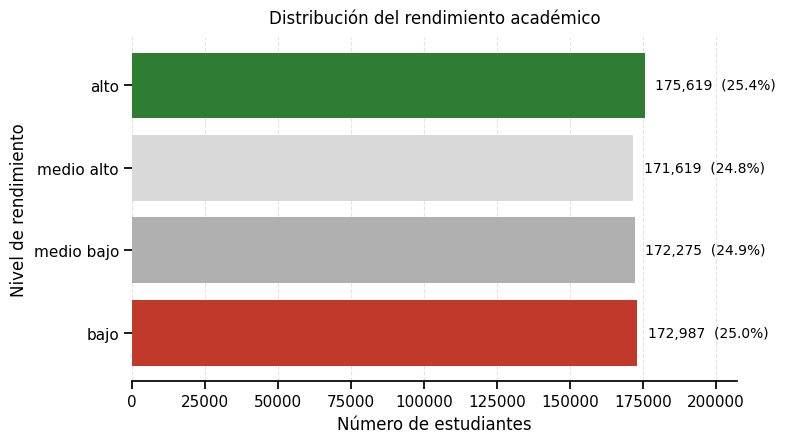

In [357]:
target_map = {'bajo': 0, 'medio-bajo': 1, 'medio-alto': 2, 'alto': 3}
# Mapeo inverso para mostrar texto en vez de 0-3
inv_target_map = {v: k for k, v in target_map.items()}

# Orden explícito (de menor a mayor)
order = ["bajo", "medio-bajo", "medio-alto", "alto"]
order_codes = [target_map[k] for k in order]

counts = data_imp["RENDIMIENTO_GLOBAL"].value_counts().reindex(order_codes)
labels = order
values = counts.values
total = values.sum()
pct = values / total

color_map = {
    "bajo": "#C0392B",        # rojo apagado
    "medio-bajo": "#B0B0B0",  # gris medio
    "medio-alto": "#D9D9D9",  # gris claro
    "alto": "#2E7D32"         # verde apagado
}
colors = [color_map[l] for l in labels]

fig, ax = plt.subplots(figsize=(8, 4.6))

y = np.arange(len(labels))
bars = ax.barh(y, values, color=colors)

# Etiquetas y formato
ax.set_yticks(y)
ax.set_yticklabels([l.replace("-", " ") for l in labels])  # “medio bajo”, etc.
ax.set_xlabel("Número de estudiantes")
ax.set_title("Distribución del rendimiento académico", pad=10)
ax.set_ylabel("Nivel de rendimiento")

# Grid sutil y limpieza (look “report”)
ax.xaxis.grid(True, linestyle="--", linewidth=0.8, alpha=0.35)
ax.set_axisbelow(True)
for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)

# Anotaciones (conteo + porcentaje) al final de cada barra
xmax = values.max()
ax.set_xlim(0, xmax * 1.18)  # espacio para texto

for i, (v, p) in enumerate(zip(values, pct)):
    ax.text(v + xmax * 0.02, i, f"{v:,.0f}  ({p:.1%})", va="center", fontsize=10)

plt.tight_layout()
plt.show()



#### Gráficos KPI (brechas) — KRAS, FD, KCC

KRAS

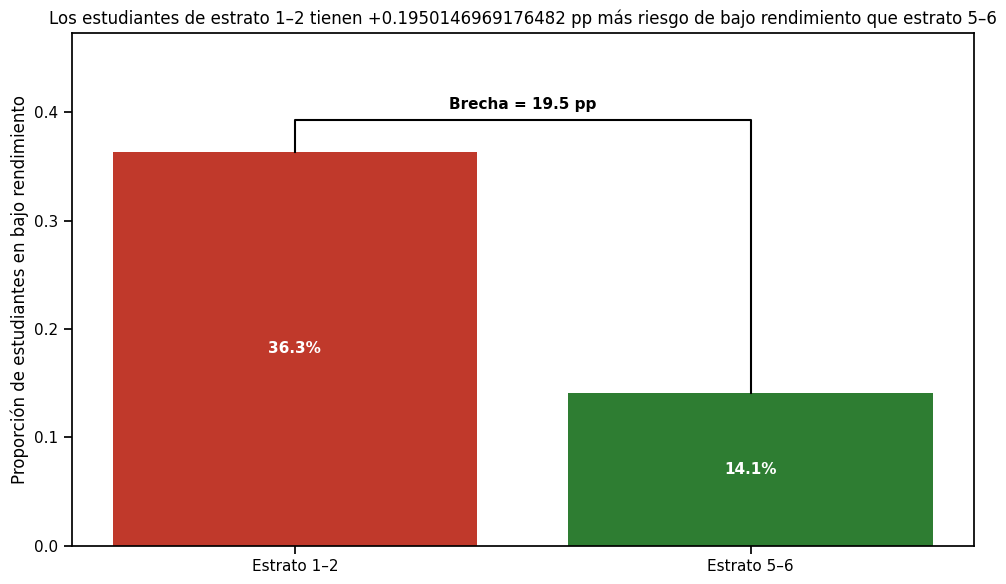

In [358]:
labels = ["Estrato 1–2", "Estrato 5–6"]
values = [p_low, p_high]
plt.figure(figsize=(10,6))
bars = plt.bar(labels, values, color=["#C0392B", "#2E7D32"])

plt.ylabel("Proporción de estudiantes en bajo rendimiento")
plt.title("Brecha socioeconómica en el rendimiento académico")

# Porcentajes dentro de las barras
for bar in bars:
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             y/2,
             f"{y*100:.1f}%",
             ha="center",
             va="center",
             color="white",
             fontweight="bold",
             fontsize=11)

# Llave de la brecha
x1, x2 = 0, 1
y1, y2 = values
y_bracket = max(values) + 0.03

plt.plot([x1, x1, x2, x2],
         [y1, y_bracket, y_bracket, y2],
         color="black", linewidth=1.5)

plt.text(0.5, y_bracket + 0.01,
         f"Brecha = {KRAS*100:.1f} pp",
         ha="center",
         fontsize=11,
         fontweight="bold")

plt.ylim(0, y_bracket + 0.08)
plt.tight_layout()
plt.show()

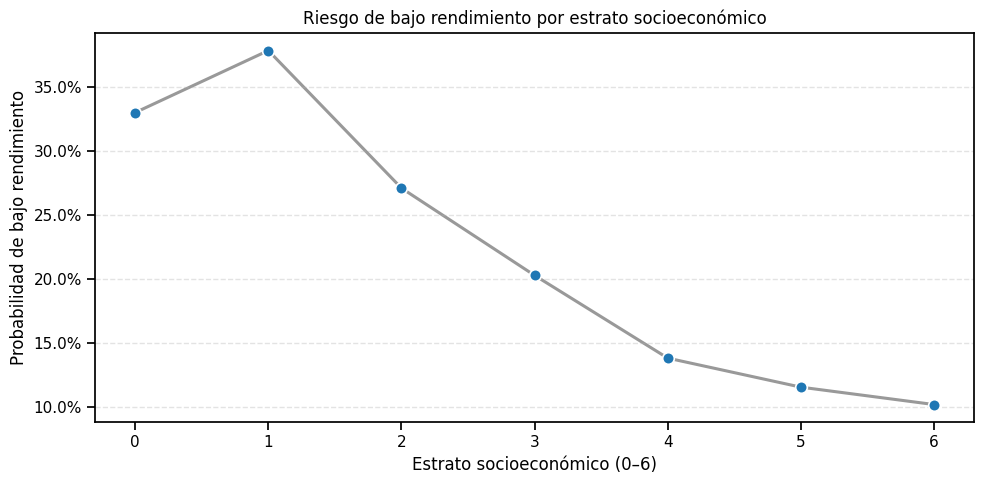

In [359]:
def pct_axis(ax):
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))


def plot_kras_gradient(
    data_imp,
    target,
    estrato_col="F_ESTRATOVIVIENDA",
    low_class=0
):
    if estrato_col not in data_imp.columns:
        print(f"[WARN] No existe la columna {estrato_col}")
        return

    # Agregación
    t = (
        data_imp
        .assign(BAJO=(data_imp[target] == low_class).astype(int))
        .groupby(estrato_col)["BAJO"]
        .agg(p_bajo="mean", N="size")
        .sort_index()
    )

    # Filtrar estratos válidos (0–6)
    t = t.loc[t.index.isin([0, 1, 2, 3, 4, 5, 6])]

    x = t.index.astype(int).values
    y = t["p_bajo"].values

    fig, ax = plt.subplots(figsize=(10, 5))

    # Línea gris (contexto)
    ax.plot(
        x, y,
        color="0.6",
        linewidth=2.2,
        zorder=1
    )

    # Puntos de color (datos)
    ax.scatter(
        x, y,
        s=70,
        color="tab:blue",
        edgecolor="white",
        linewidth=1.2,
        zorder=2
    )

    # Ejes y etiquetas
    ax.set_xticks(x)
    ax.set_xlabel("Estrato socioeconómico (0–6)")
    ax.set_ylabel("Probabilidad de bajo rendimiento")
    ax.set_title("Riesgo de bajo rendimiento por estrato socioeconómico")

    # Formato porcentaje
    pct_axis(ax)

    # Grid sutil (no protagonista)
    ax.grid(True, axis="y", linestyle="--", alpha=0.35)
    ax.grid(False, axis="x")

    # Mostrar tamaño de muestra (buena práctica en educación)
    for xi, ni in zip(x, t["N"].values):
        ax.annotate(
            f"n={ni}",
            (xi, 0),
            xytext=(0, -18),
            textcoords="offset points",
            ha="center",
            va="top",
            fontsize=8,
            color="0.4"
        )

    plt.tight_layout()
    plt.show()

plot_kras_gradient(
    data_imp=data_imp,
    target=TARGET
)

FD

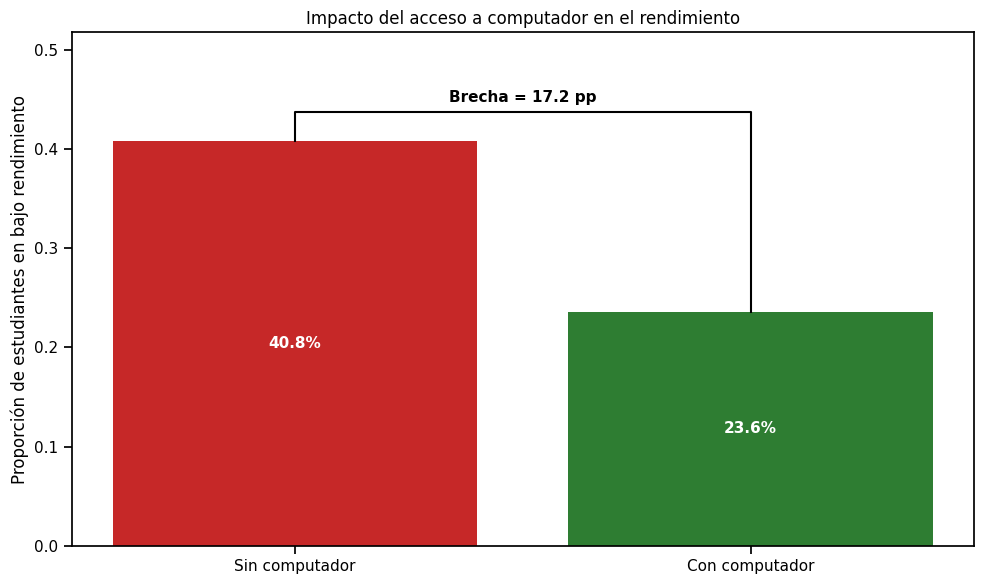

In [315]:
labels = ["Sin computador", "Con computador"]
values = [p_no, p_pc]

plt.figure(figsize=(10,6))
bars = plt.bar(labels, values, color=["#C62828", "#2E7D32"])

plt.ylabel("Proporción de estudiantes en bajo rendimiento")
plt.title("Impacto del acceso a computador en el rendimiento")

# Porcentajes dentro de las barras
for bar in bars:
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             y/2,
             f"{y*100:.1f}%",
             ha="center",
             va="center",
             color="white",
             fontweight="bold",
             fontsize=11)

# Dibujar brecha
x1, x2 = 0, 1
y1, y2 = values
y_bracket = max(values) + 0.03

plt.plot([x1, x1, x2, x2],
         [y1, y_bracket, y_bracket, y2],
         color="black", linewidth=1.5)

plt.text(0.5, y_bracket + 0.01,
         f"Brecha = {FD*100:.1f} pp",
         ha="center",
         fontsize=11,
         fontweight="bold")

plt.ylim(0, y_bracket + 0.08)
plt.tight_layout()
plt.show()


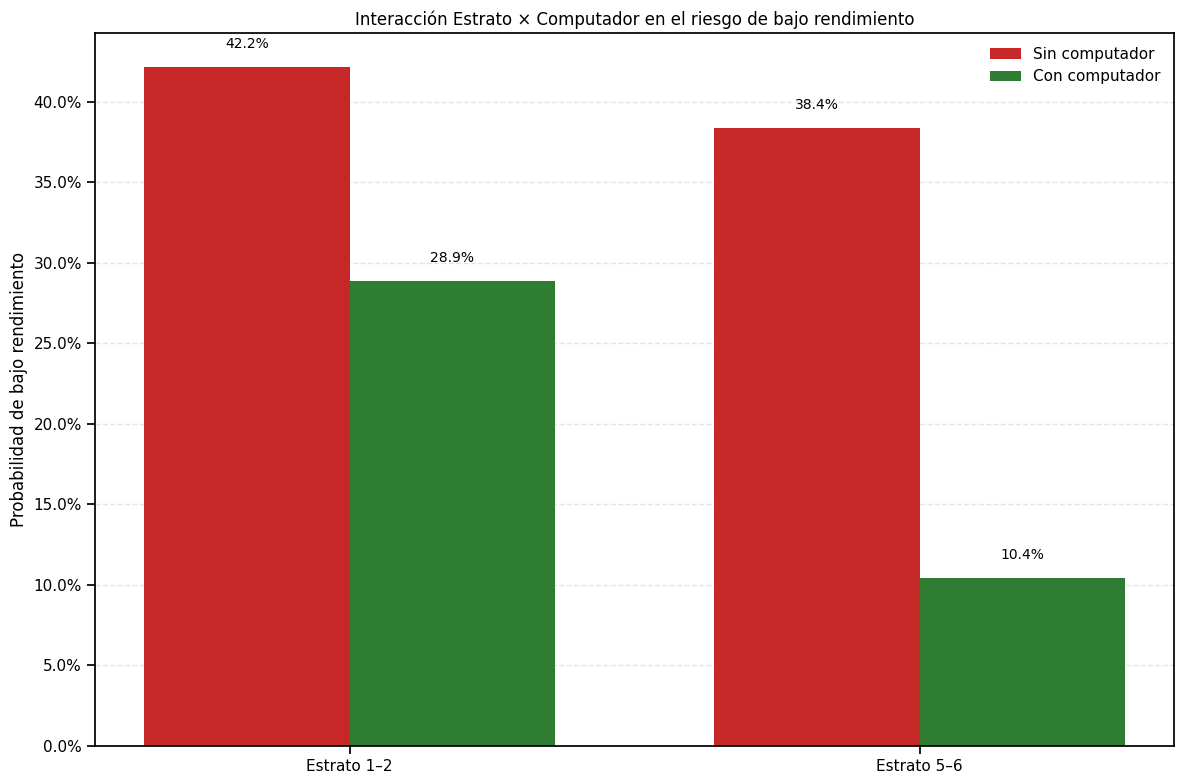

In [343]:
def pct_axis(ax):
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))


def plot_fd_interaction(
    data_imp,
    target,
    low_class=0,
    estrato_col="F_ESTRATOVIVIENDA",
    pc_col="F_TIENECOMPUTADOR"
):
    if estrato_col not in data_imp.columns or pc_col not in data_imp.columns:
        print(f"[WARN] Falta {estrato_col} o {pc_col}")
        return

    # Definición de segmentos extremos
    low_str  = data_imp[estrato_col].isin([1, 2])
    high_str = data_imp[estrato_col].isin([5, 6])

    df2 = data_imp.loc[low_str | high_str, [target, pc_col, estrato_col]].copy()

    df2["SEG_ESTRATO"] = np.where(
        df2[estrato_col].isin([1, 2]),
        "Estrato 1–2",
        "Estrato 5–6"
    )

    df2["PC"] = np.where(
        df2[pc_col] == 1,
        "Con computador",
        "Sin computador"
    )

    df2["BAJO"] = (df2[target] == low_class).astype(int)

    # Agregación
    g = (
        df2
        .groupby(["SEG_ESTRATO", "PC"])["BAJO"]
        .mean()
        .unstack("PC")
        .reindex(
            index=["Estrato 1–2", "Estrato 5–6"],
            columns=["Sin computador", "Con computador"]
        )
    )

    x = np.arange(len(g.index))
    width = 0.36

    fig, ax = plt.subplots(figsize=(12, 8))

    # Rojo = mayor riesgo (sin computador)
    ax.bar(
        x - width/2,
        g["Sin computador"].values,
        width,
        color="#C62828",          # rojo sobrio
        label="Sin computador",
        zorder=2
    )

    # Verde = menor riesgo (con computador)
    ax.bar(
        x + width/2,
        g["Con computador"].values,
        width,
        color="#2E7D32",          # verde sobrio
        label="Con computador",
        zorder=2
    )

    # Ejes y etiquetas
    ax.set_xticks(x)
    ax.set_xticklabels(g.index)
    ax.set_ylabel("Probabilidad de bajo rendimiento")
    ax.set_title("Interacción Estrato × Computador en el riesgo de bajo rendimiento")

    # Formato porcentaje
    pct_axis(ax)

    # Grid sutil
    ax.grid(True, axis="y", linestyle="--", alpha=0.35, zorder=1)
    ax.grid(False, axis="x")

    # Etiquetas de valor (mejora lectura sin forzar leyenda)
    for i, estrato in enumerate(g.index):
        for j, col in enumerate(g.columns):
            val = g.loc[estrato, col]
            xpos = x[i] + (-width/2 if col == "Sin computador" else width/2)
            ax.text(
                xpos,
                val + 0.01,
                f"{val:.1%}",
                ha="center",
                va="bottom",
                fontsize=10,
                color="black"
            )

    # Leyenda clara (no redundante)
    ax.legend(frameon=False)

    plt.tight_layout()
    plt.show()

plot_fd_interaction(
    data_imp=data_imp,
    target=TARGET
)

KCC

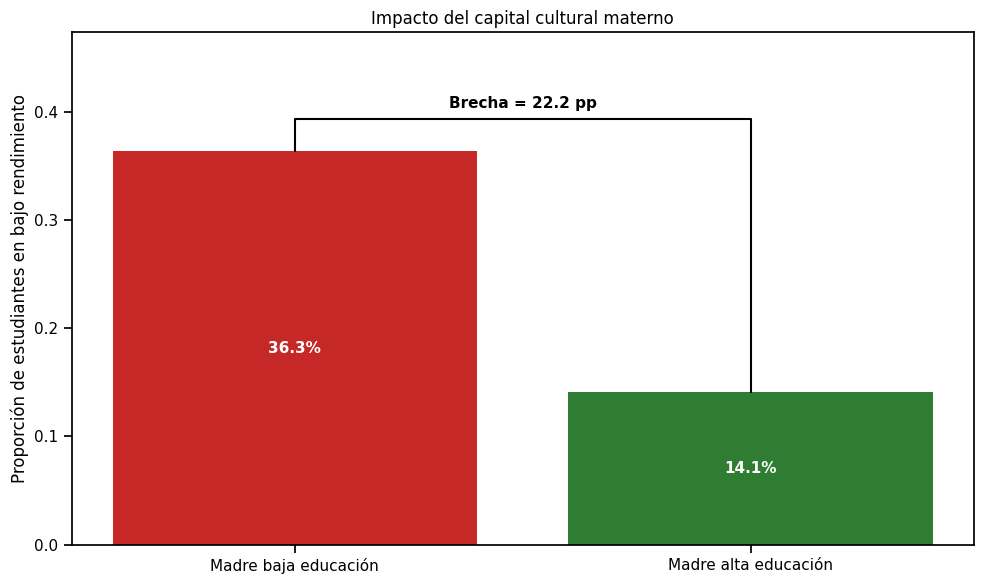

In [316]:
labels = ["Madre baja educación", "Madre alta educación"]
values = [p_low, p_high]

plt.figure(figsize=(10,6))
bars = plt.bar(labels, values, color=["#C62828", "#2E7D32"])

plt.ylabel("Proporción de estudiantes en bajo rendimiento")
plt.title("Impacto del capital cultural materno")

# Valores dentro de las barras
for bar in bars:
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             y / 2,
             f"{y*100:.1f}%",
             ha="center",
             va="center",
             color="white",
             fontweight="bold",
             fontsize=11)

# Llave de la brecha
x1, x2 = 0, 1
y1, y2 = values
y_bracket = max(values) + 0.03

plt.plot([x1, x1, x2, x2],
         [y1, y_bracket, y_bracket, y2],
         color="black", linewidth=1.5)

plt.text(0.5, y_bracket + 0.01,
         f"Brecha = {KCC*100:.1f} pp",
         ha="center",
         fontsize=11,
         fontweight="bold")

plt.ylim(0, y_bracket + 0.08)
plt.tight_layout()
plt.show()


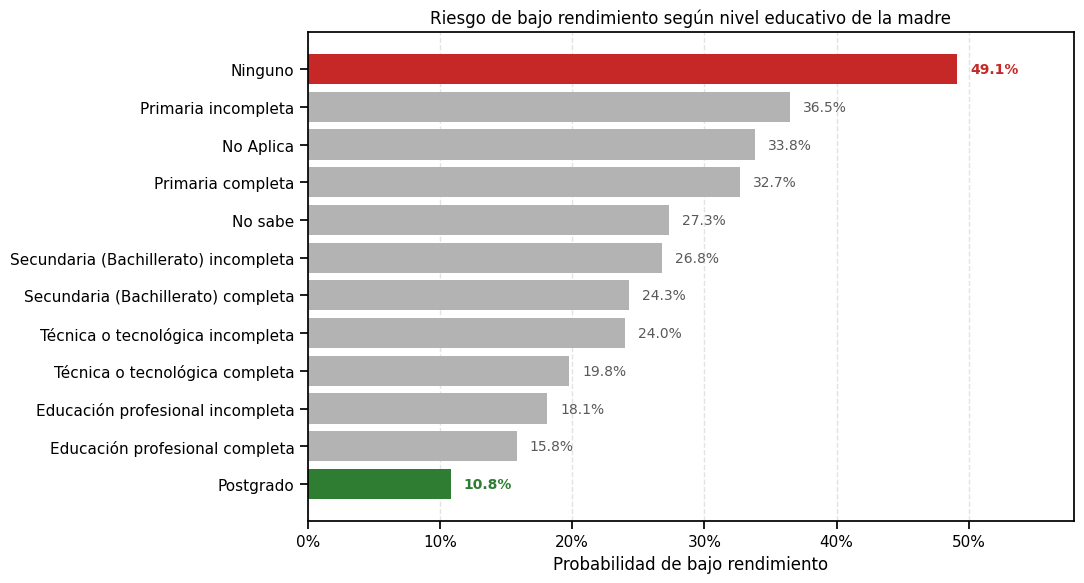

In [347]:
def plot_kcc_mother_education(
    data_imp,
    target,
    low_class=0,
    mom_col="F_EDUCACIONMADRE"
):
    if mom_col not in data_imp.columns:
        print(f"[WARN] No existe la columna {mom_col}")
        return

    df2 = data_imp[[target, mom_col]].copy()
    df2 = df2.dropna(subset=[mom_col])
    df2["BAJO"] = (df2[target] == low_class).astype(int)

    # Agregación (mayor → menor)
    t = (
        df2
        .groupby(mom_col)["BAJO"]
        .agg(p_bajo="mean", N="size")
        .sort_values("p_bajo", ascending=False)
    )

    # Colores: mayor rojo, menor verde, resto gris
    colors = ["0.7"] * len(t)
    colors[0]  = "#C62828"
    colors[-1] = "#2E7D32"

    fig, ax = plt.subplots(figsize=(11, 6))

    ax.barh(t.index, t["p_bajo"].values, color=colors, zorder=2)
    ax.invert_yaxis()

    ax.set_xlabel("Probabilidad de bajo rendimiento")
    ax.set_title("Riesgo de bajo rendimiento según nivel educativo de la madre")
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    ax.grid(True, axis="x", linestyle="--", alpha=0.35, zorder=1)
    ax.grid(False, axis="y")

    xmax = t["p_bajo"].max()
    ax.set_xlim(0, xmax * 1.18)   # +18% de espacio a la derecha

    offset = xmax * 0.02          # separación proporcional
    for i, (cat, row) in enumerate(t.iterrows()):
        val = row["p_bajo"]

        # color del texto: extremos con sus colores, resto gris oscuro
        if i == 0:
            txt_color = "#C62828"
            fw = "bold"
        elif i == len(t) - 1:
            txt_color = "#2E7D32"
            fw = "bold"
        else:
            txt_color = "0.35"
            fw = "normal"

        ax.text(
            val + offset,
            cat,
            f"{val:.1%}",
            va="center",
            ha="left",
            fontsize=10,
            fontweight=fw,
            color=txt_color
        )

    plt.tight_layout()
    plt.show()

# Ejecución
plot_kcc_mother_education(data_imp=data_imp, target=TARGET)


#### KPI territorial — riesgo por región y casos absolutos

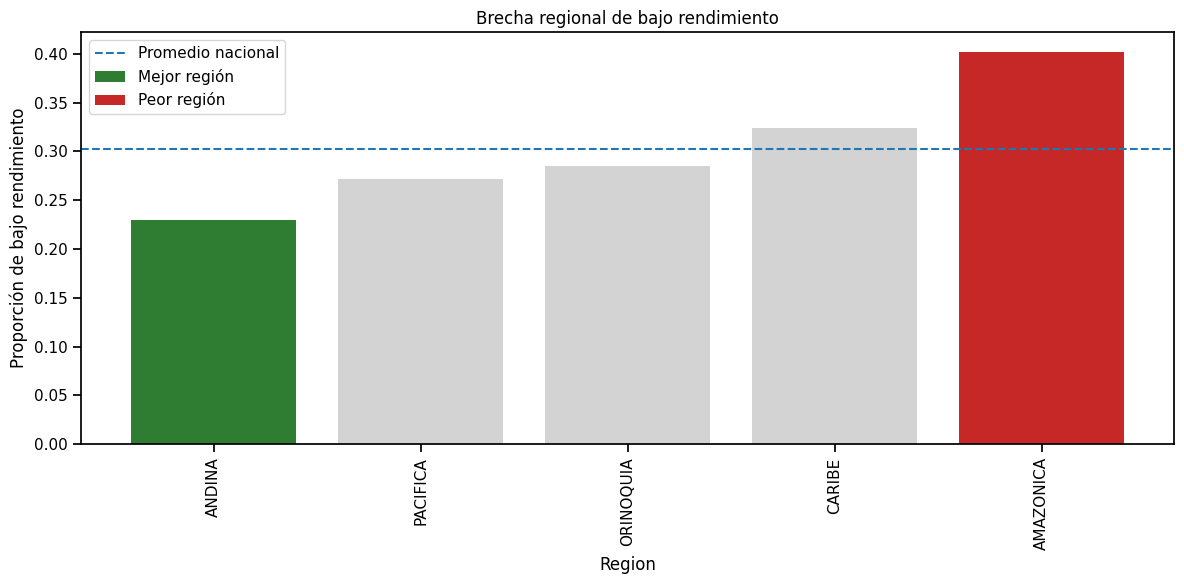

Mejor región: ANDINA 23.01 %
Peor región: AMAZONICA 40.2 %
Brecha: 17.19 puntos porcentuales


In [360]:
labels = regional_risk.index.tolist()
values = regional_risk.values

best = regional_risk.idxmin()
worst = regional_risk.idxmax()

x = np.arange(len(labels))

plt.figure(figsize=(12,6))
plt.bar(x, values, color="lightgray")

# posiciones correctas
best_idx = labels.index(best)
worst_idx = labels.index(worst)

plt.bar(best_idx, values[best_idx], color="#2E7D32", label="Mejor región")
plt.bar(worst_idx, values[worst_idx], color="#C62828", label="Peor región")

plt.xticks(x, labels, rotation=90)
plt.ylabel("Proporción de bajo rendimiento")
plt.xlabel("Region")
plt.title("Brecha regional de bajo rendimiento")
plt.axhline(regional_risk.mean(), linestyle="--", label="Promedio nacional")
plt.legend()
plt.tight_layout()
plt.show()

print("Mejor región:", best, round(values[best_idx]*100,2), "%")
print("Peor región:", worst, round(values[worst_idx]*100,2), "%")
print("Brecha:", round((values[worst_idx] - values[best_idx])*100,2), "puntos porcentuales")

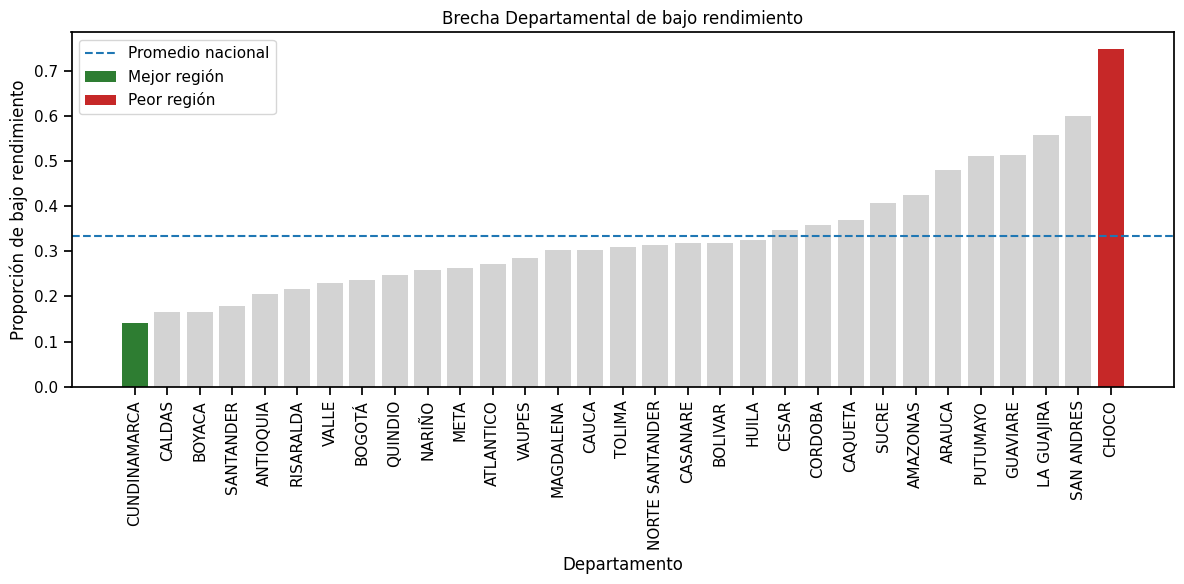

Mejor región: CUNDINAMARCA 14.12 %
Peor región: CHOCO 74.75 %
Brecha: 60.63 puntos porcentuales


In [361]:
labels = regional_risk_d.index.tolist()
values = regional_risk_d.values

best = regional_risk_d.idxmin()
worst = regional_risk_d.idxmax()

x = np.arange(len(labels))

plt.figure(figsize=(12,6))
plt.bar(x, values, color="lightgray")

# posiciones correctas
best_idx = labels.index(best)
worst_idx = labels.index(worst)

plt.bar(best_idx, values[best_idx], color="#2E7D32", label="Mejor región")
plt.bar(worst_idx, values[worst_idx], color="#C62828", label="Peor región")

plt.xticks(x, labels, rotation=90)
plt.ylabel("Proporción de bajo rendimiento")
plt.xlabel("Departamento")
plt.title("Brecha Departamental de bajo rendimiento")
plt.axhline(regional_risk_d.mean(), linestyle="--", label="Promedio nacional")
plt.legend()
plt.tight_layout()
plt.show()

print("Mejor región:", best, round(values[best_idx]*100,2), "%")
print("Peor región:", worst, round(values[worst_idx]*100,2), "%")
print("Brecha:", round((values[worst_idx] - values[best_idx])*100,2), "puntos porcentuales")

#### KDS

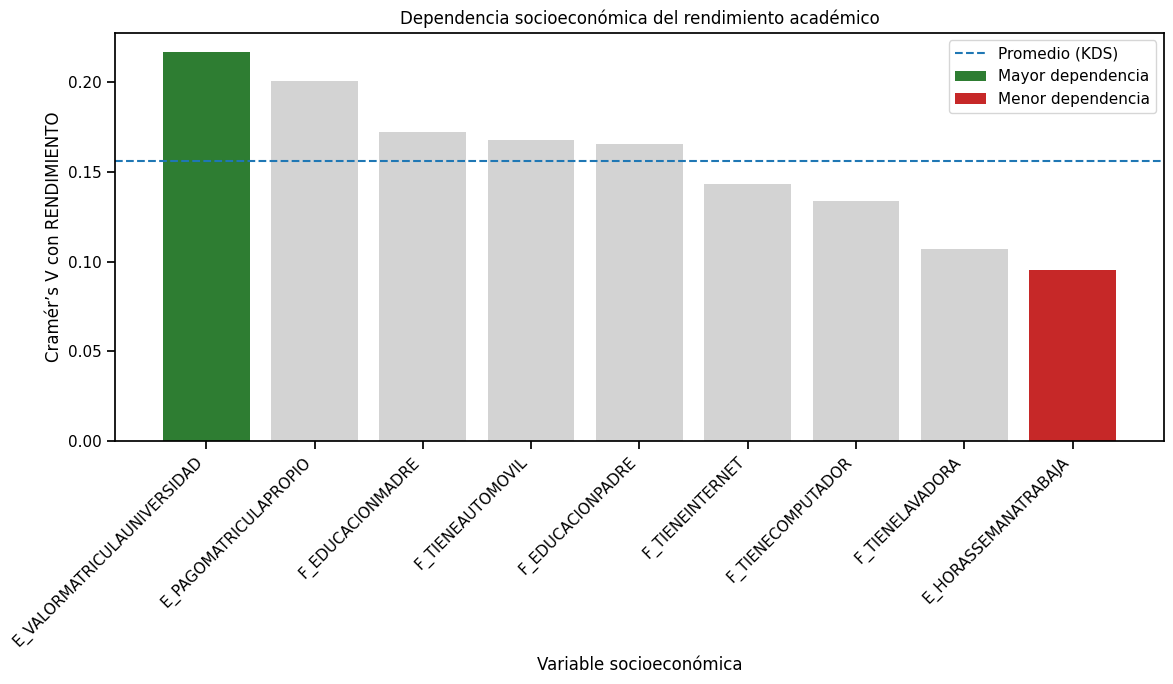

Variable más influyente: E_VALORMATRICULAUNIVERSIDAD 0.217
Variable menos influyente: E_HORASSEMANATRABAJA 0.095
Brecha: 0.121


In [362]:
comparison_sorted = comparison["Después"].sort_values(ascending=False)
labels = comparison_sorted.index.tolist()
values = comparison_sorted.values

best = comparison_sorted.idxmax()
worst = comparison_sorted.idxmin()
x = np.arange(len(labels))
plt.figure(figsize=(12,7))


plt.bar(x, values, color="lightgray")
best_idx = labels.index(best)
worst_idx = labels.index(worst)
plt.bar(best_idx, values[best_idx], color="#2E7D32", label="Mayor dependencia")
plt.bar(worst_idx, values[worst_idx], color="#C62828", label="Menor dependencia")

# línea promedio
plt.axhline(KDS, linestyle="--", label="Promedio (KDS)")

# ejes
plt.xticks(x, labels, rotation=45, ha="right")
plt.ylabel("Cramér’s V con RENDIMIENTO")
plt.xlabel("Variable socioeconómica")
plt.title("Dependencia socioeconómica del rendimiento académico")
plt.legend()
plt.tight_layout()
plt.show()

# métricas ejecutivas
print("Variable más influyente:", best, round(values[best_idx], 3))
print("Variable menos influyente:", worst, round(values[worst_idx], 3))
print("Brecha:", round(values[best_idx] - values[worst_idx], 3))

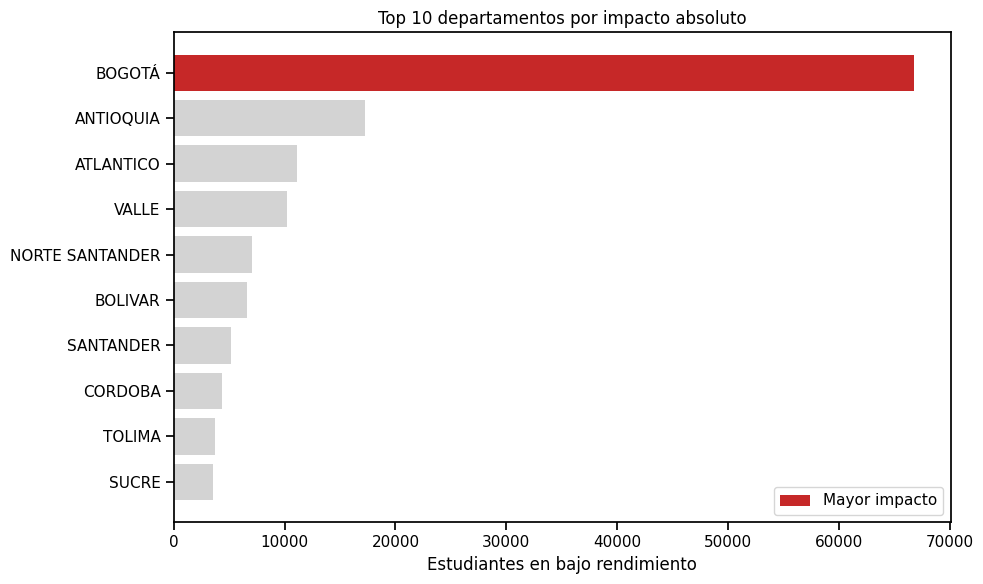

In [320]:
top10 = kpi_dept.head(10)

plt.figure(figsize=(10,6))
plt.barh(top10.index, top10["casos"], color="lightgray")

plt.barh(top10.index[0], top10["casos"].iloc[0], color="#C62828", label="Mayor impacto")

plt.xlabel("Estudiantes en bajo rendimiento")
plt.title("Top 10 departamentos por impacto absoluto")
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()
plt.show()

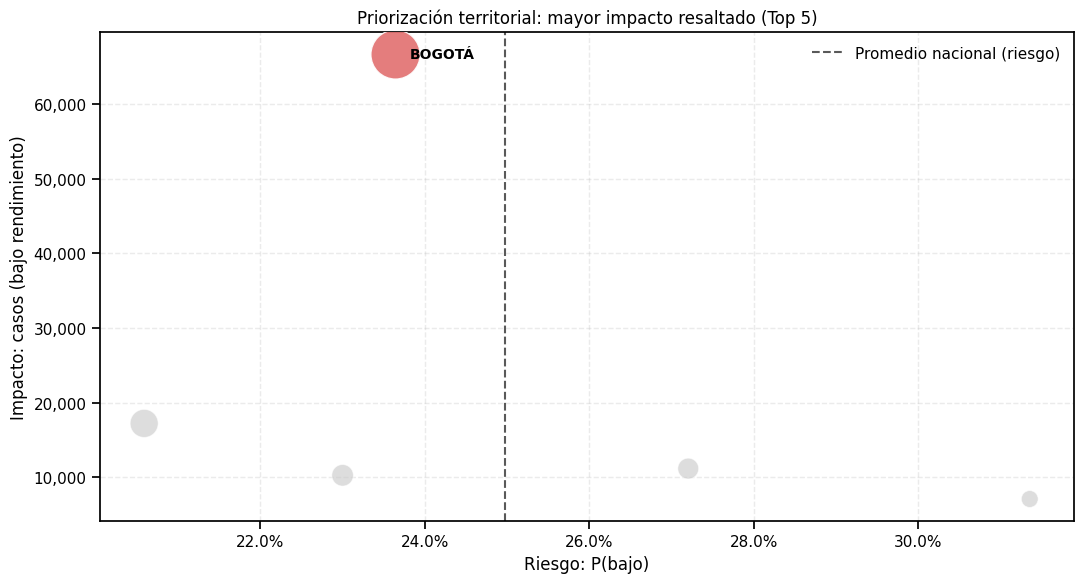

In [356]:
def plot_impact_risk_bubble(kpi_dept, p_nat=None, top_n=40):
    needed = {"N","p_bajo","casos"}
    if not needed.issubset(set(kpi_dept.columns)):
        print(f"[WARN] kpi_dept debe tener columnas {needed}. Tiene: {kpi_dept.columns.tolist()}")
        return

    # Top N por casos
    dfb = kpi_dept.sort_values("casos", ascending=False).head(top_n).copy()

    x = dfb["p_bajo"].values
    y = dfb["casos"].values
    sizes = (dfb["N"].values / dfb["N"].max()) * 1200 + 50

    top_dept = dfb.index[0]

    fig, ax = plt.subplots(figsize=(11,6))

    # Contexto: gris
    ax.scatter(
        x, y,
        s=sizes,
        color="0.78",
        alpha=0.6,
        edgecolor="white",
        linewidth=0.6,
        zorder=2
    )

    # Foco: rojo claro
    ax.scatter(
        dfb.loc[top_dept, "p_bajo"],
        dfb.loc[top_dept, "casos"],
        s=(dfb.loc[top_dept, "N"] / dfb["N"].max()) * 1200 + 50,
        color="#E57373",
        alpha=0.9,
        edgecolor="white",
        linewidth=0.9,
        zorder=3
    )

    # Etiqueta en NEGRO (no compite con el color)
    ax.annotate(
        str(top_dept),
        xy=(dfb.loc[top_dept, "p_bajo"], dfb.loc[top_dept, "casos"]),
        xytext=(10, 0),
        textcoords="offset points",
        va="center",
        fontsize=10,
        fontweight="bold",
        color="black"
    )

    # Línea de referencia nacional
    if p_nat is not None:
        ax.axvline(
            p_nat,
            linestyle="--",
            linewidth=1.5,
            color="0.35",
            label="Promedio nacional (riesgo)"
        )

    # Formato
    ax.set_xlabel("Riesgo: P(bajo)")
    ax.set_ylabel("Impacto: casos (bajo rendimiento)")
    ax.set_title(f"Priorización territorial: mayor impacto resaltado (Top {top_n})")
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

    ax.grid(True, linestyle="--", alpha=0.25)
    if p_nat is not None:
        ax.legend(frameon=False)

    plt.tight_layout()
    plt.show()

# Ejecución
plot_impact_risk_bubble(kpi_dept, p_nat=p_nat, top_n=5)



Aunque Chocó o la Guajira tienen peor porcentaje, Bogotá concentra el mayor número absoluto de estudiantes en bajo rendimiento del país (66 mil).
Intervenir Bogotá produce más impacto nacional que cualquier otro territorio.

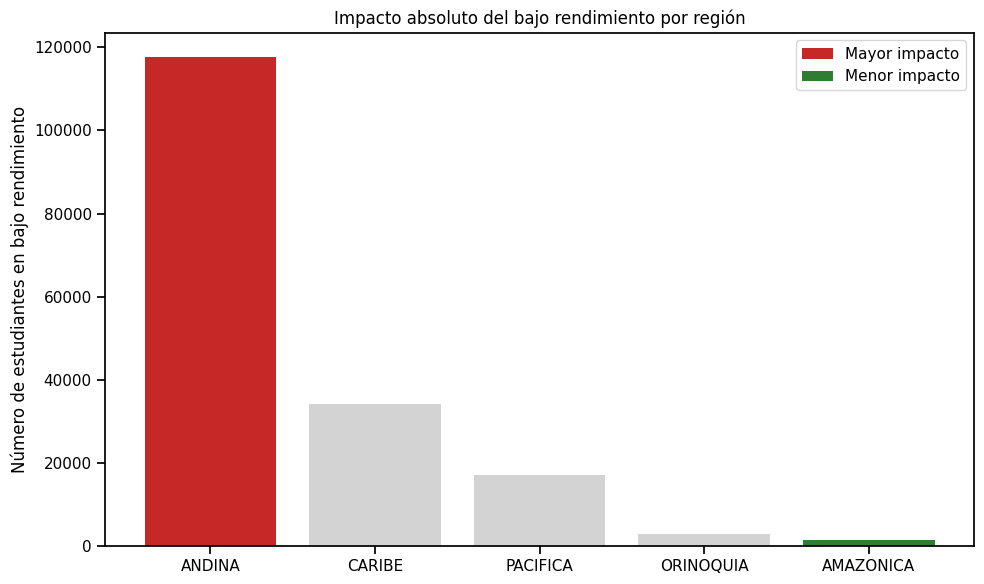

In [321]:
kpi_region_plot = kpi_region.sort_values("casos", ascending=False)

labels = kpi_region_plot.index
values = kpi_region_plot["casos"]

best = values.idxmax()
worst = values.idxmin()

x = np.arange(len(labels))

plt.figure(figsize=(10,6))
plt.bar(x, values, color="lightgray")

best_idx = labels.tolist().index(best)
worst_idx = labels.tolist().index(worst)

plt.bar(best_idx, values.iloc[best_idx], color="#C62828", label="Mayor impacto")
plt.bar(worst_idx, values.iloc[worst_idx], color="#2E7D32", label="Menor impacto")

plt.xticks(x, labels, rotation=0)
plt.ylabel("Número de estudiantes en bajo rendimiento")
plt.title("Impacto absoluto del bajo rendimiento por región")
plt.legend()
plt.tight_layout()
plt.show()

Andina no es la región más pobre, pero concentra el 55% de todos los casos de bajo rendimiento del país.
Amazonía es la más vulnerable, pero no la más relevante en volumen

#### Segmentos **critícos**

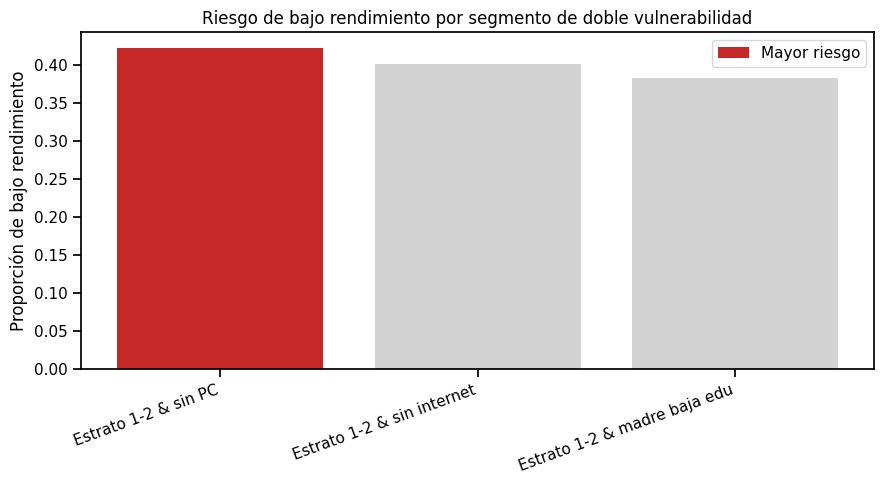

In [322]:
plt.figure(figsize=(9,5))

plt.bar(
    kpi_segments["segmento"],
    kpi_segments["p_bajo"],
    color="lightgray"
)

# resaltar el más crítico
idx = kpi_segments["p_bajo"].idxmax()
plt.bar(
    kpi_segments.loc[idx, "segmento"],
    kpi_segments.loc[idx, "p_bajo"],
    color="#C62828",
    label="Mayor riesgo"
)

plt.ylabel("Proporción de bajo rendimiento")
plt.title("Riesgo de bajo rendimiento por segmento de doble vulnerabilidad")
plt.xticks(rotation=20, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

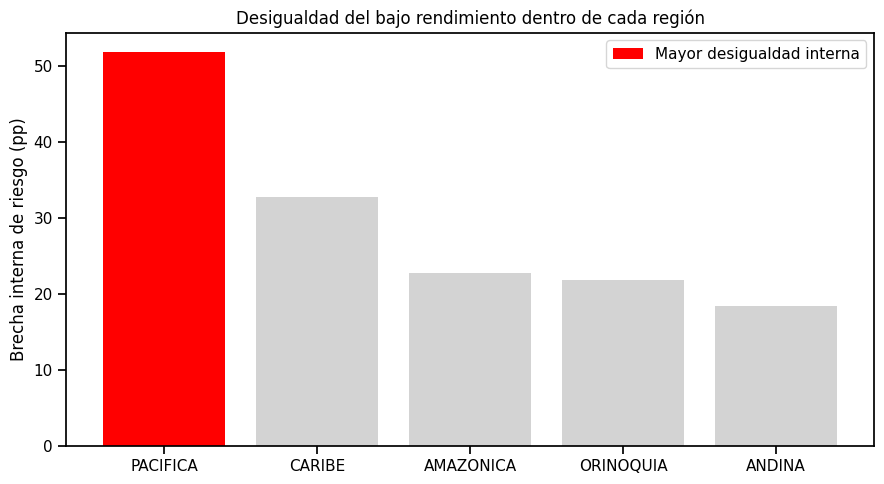

In [365]:
dept_risk = (
    data_imp.assign(BAJO=is_low.astype(int))
    .groupby([REGION, DEPT])["BAJO"]
    .mean()
    .reset_index(name="p_bajo")
)

kpi_ineq_region = (
    dept_risk.groupby(REGION)["p_bajo"]
    .agg(
        p10=lambda s: s.quantile(0.10),
        p90=lambda s: s.quantile(0.90),
        max_=("max"),
        min_=("min")
    )
)

kpi_ineq_region["brecha_p90_p10_pp"] = (kpi_ineq_region["p90"] - kpi_ineq_region["p10"]) * 100
kpi_ineq_region["brecha_max_min_pp"] = (kpi_ineq_region["max_"] - kpi_ineq_region["min_"]) * 100

kpi_ineq_region.sort_values("brecha_max_min_pp", ascending=False)

ineq = kpi_ineq_region.sort_values("brecha_max_min_pp", ascending=False)

plt.figure(figsize=(9,5))
plt.bar(ineq.index, ineq["brecha_max_min_pp"], color="lightgray")

# resaltar la peor
worst = ineq["brecha_max_min_pp"].idxmax()
plt.bar(worst, ineq.loc[worst, "brecha_max_min_pp"], color="red", label="Mayor desigualdad interna")

plt.ylabel("Brecha interna de riesgo (pp)")
plt.title("Desigualdad del bajo rendimiento dentro de cada región")
plt.legend()
plt.tight_layout()
plt.show()



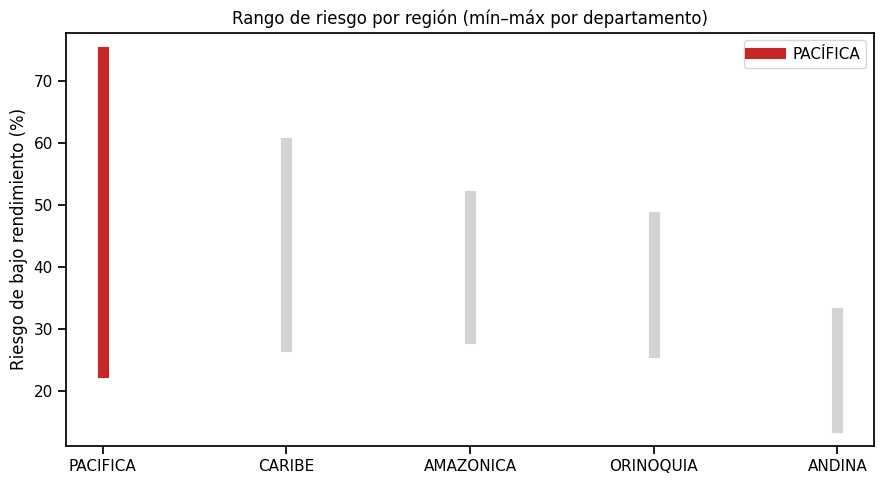

In [366]:
plt.figure(figsize=(9,5))

for i, region in enumerate(ineq.index):
    plt.plot(
        [region, region],
        [kpi_ineq_region.loc[region, "min_"]*100,
         kpi_ineq_region.loc[region, "max_"]*100],
        linewidth=8,
        color="lightgray"
    )

# resaltar Pacífica
plt.plot(
    ["PACIFICA","PACIFICA"],
    [kpi_ineq_region.loc["PACIFICA","min_"]*100,
     kpi_ineq_region.loc["PACIFICA","max_"]*100],
    linewidth=8,
    color="#C62828",
    label="PACÍFICA"
)

plt.ylabel("Riesgo de bajo rendimiento (%)")
plt.title("Rango de riesgo por región (mín–máx por departamento)")
plt.legend()
plt.tight_layout()
plt.show()

La región Pacífica es la más desigual del país:
dentro de ella, el riesgo varía entre 23% y 75%.
Eso significa que Chocó requiere una política completamente distinta a Valle

Δ riesgo (sinPC - conPC): 17.21 pp
N sin PC: 56745
Casos evitables (proxy): 9769
Δ riesgo (sinInternet - conInternet): 16.17 pp
Casos evitables (proxy): 11873


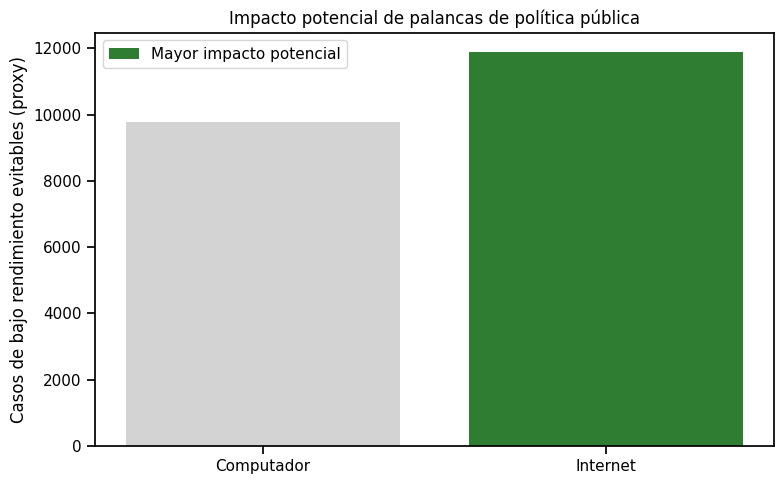

In [363]:
# Dotación de computador
p_no = (data_imp.loc[data_imp["F_TIENECOMPUTADOR"]==0, TARGET]==0).mean()
p_yes = (data_imp.loc[data_imp["F_TIENECOMPUTADOR"]==1, TARGET]==0).mean()

delta = p_no - p_yes
N_no = int((data_imp["F_TIENECOMPUTADOR"]==0).sum())

casos_evitable_proxy = N_no * delta

print("Δ riesgo (sinPC - conPC):", round(delta*100,2), "pp")
print("N sin PC:", N_no)
print("Casos evitables (proxy):", int(round(casos_evitable_proxy)))

"""Si los estudiantes que hoy no tienen computador se comportaran como los que sí lo tienen,
el país tendría ~9,800 estudiantes menos en bajo rendimiento.
"""

# Internet
p_no = (data_imp.loc[data_imp["F_TIENEINTERNET"]==0, TARGET]==0).mean()
p_yes = (data_imp.loc[data_imp["F_TIENEINTERNET"]==1, TARGET]==0).mean()

delta_net = p_no - p_yes
N_no_net = int((data_imp["F_TIENEINTERNET"]==0).sum())
casos_evitable_net_proxy = N_no_net * delta_net

print("Δ riesgo (sinInternet - conInternet):", round(delta_net*100,2), "pp")
print("Casos evitables (proxy):", int(round(casos_evitable_net_proxy)))

"""Si los estudiantes que hoy no tienen internet se comportaran como los que sí lo tienen,
habría ~11,900 estudiantes menos en bajo rendimiento.
"""

palancas = ["Computador", "Internet"]
casos = [casos_evitable_proxy, casos_evitable_net_proxy]

plt.figure(figsize=(8,5))
plt.bar(palancas, casos, color="lightgray")

# resaltar la más potente
max_idx = np.argmax(casos)
plt.bar(palancas[max_idx], casos[max_idx], color="#2E7D32", label="Mayor impacto potencial")

plt.ylabel("Casos de bajo rendimiento evitables (proxy)")
plt.title("Impacto potencial de palancas de política pública")
plt.legend()
plt.tight_layout()
plt.show()


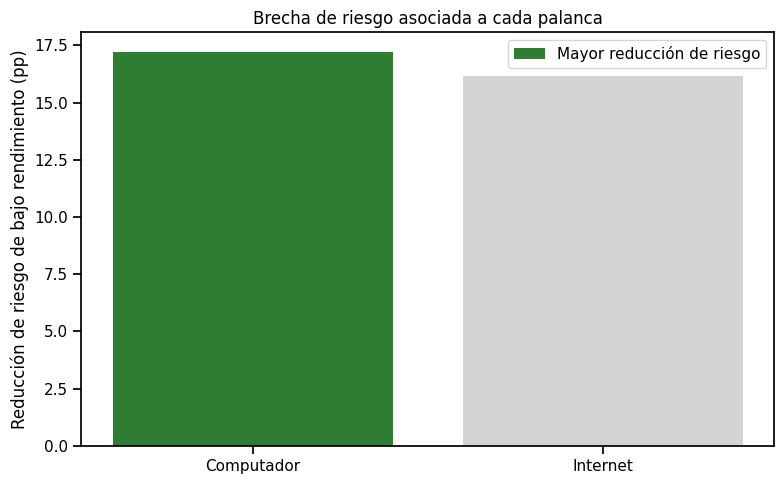

In [364]:
deltas = [delta*100, delta_net*100]

plt.figure(figsize=(8,5))
plt.bar(palancas, deltas, color="lightgray")

max_idx = np.argmax(deltas)
plt.bar(palancas[max_idx], deltas[max_idx], color="#2E7D32", label="Mayor reducción de riesgo")

plt.ylabel("Reducción de riesgo de bajo rendimiento (pp)")
plt.title("Brecha de riesgo asociada a cada palanca")
plt.legend()
plt.tight_layout()
plt.show()